# Autoencoders

David Solís Martín  <br>
Miguel A. Gutiérrez Naranjo

_Versión del 8 de mayo de 2020_

In [1]:
# Este trozo de código no es necesario
# pero sirve para evitar los warnings

from warnings import simplefilter
simplefilter(action = 'ignore',category = FutureWarning )

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np
sink = np.seterr(divide='ignore', invalid='ignore')

En esta práctica usaremos dos paquetes nuevos. No son realmente necesarios, pero pueden ayudar a visualizar los procesos. El primero sirve para las gráficas de progreso de entrenamiento. Dibuja el estado de las métricas después de cada _batch_. Es el paquete _livelossplot_, que no está incluido en Anaconda, pero puede instalarse con pip;

* pip install livelossplot

El segundo es el paquete _tqdm_ que se usa para las barras de progreso. Puede instalarse con conda o con pip

* conda install -c conda-forge tqdm 
* pip install tqdm

In [2]:
# Cargamos las librerías necesarias para la práctica
import keras
from keras import models
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout, MaxPooling2D,UpSampling2D
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
from livelossplot import PlotLossesKeras
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from tqdm import tqdm
from io import BytesIO, StringIO
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image

import numpy as np
import cv2

import os, random, re, imageio, time, inspect

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Using TensorFlow backend.


In [3]:
# Por si has ejecutado antes esta práctica
# nos aseguramos de tener limpia la sesión de tensorflow
K.clear_session()

In [4]:
# Esto es solo necesario en el caso de tener varías GPUs en el equipo
# os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Introducción

Hasta el momento se han visto aplicaciones de aprendizaje supervisado con redes neuronales (convolucionales y recurrentes). Esto es, para cada muestra en nuestro conjunto de datos teníamos asociada una etiqueta o respuesta esperada.

En esta práctica vamos a trabajar en aplicaciones de aprendizaje no supervisado. Ahora no tenemos la etiqueta asociada a cada muestra, lo cuál suele ser en la vida real muy costoso de conseguir. La estructura en _Deep Learning_ por excelencia para aprendizaje no supervisado es el **autoencoder**. Esta red fue diseñada para buscar nuevas representaciones de las entradas. Para ello se divide la red en dos partes, el codificador y el decodificador. El **codificador** llevará a cabo una compresión de la entrada hasta generar un vector (llamado **vector latente**) que es una representación de nuestra entrada. El **decodificador**, tendrá que usar este vector latente para *reconstruir* la imagen original de entrada.

<img src='img/autoencoder_named.svg' width=70% />

El vector latente de es menor dimensión que la entrada. Es decir, si estamos trabajando con imágenes de 200x200 el vector debe ser de una dimensión inferior a 40000 elementos. Esta reducción de dimensionalidad obliga al codificador a quedarse con la información más importante y representativa que permita al decodificador a llevar una reconstrucción lo más fiel posible.

En cierto modo, tenemos dos redes independientes (el codificador y el decodificador) que trabajan para alcanzar un bien común. En el siguiente tema, sobre redes generativas adversarias (GANs), veremos que también se sigue este enfoque de varias redes colaborando para llevar a cabo una tarea objetivo. 


# Experimento 1

Vamos a empezar con un ejemplo muy simple. Vamos a crear un conjunto de imágenes que se diferencian unas de otras por el valor de un parámetro y vamos a crear un autoencoder con el espacio latente con dimensión 1. En principio, ese espacio latente debería ser capaz de condensar toda la información para poder reconstruir la imagen una vez entrenado el autoencoder.

Vamos a tomar un parámetro que llamamos _lado_ y vamos a crear un lienzo blanco con forma cuadrada y tantos píxeles por lado como indique ese parámetro _lado_ y luego vamos a crear todas las imágenes posibles dibujando un cuadrado negro a partir de la esquina superior izquierda.

In [5]:
def crea_cuadrados(lado):
    input_data = np.ones((lado,lado,lado,1),dtype=np.uint8)
    for i in range(lado):
        input_data[i,:i,:i,0] = 0
    return input_data

# Fijamos el valor del parámetro y creamos el conjunto de entrenamiento
mi_lado = 100
input_data = crea_cuadrados(mi_lado)

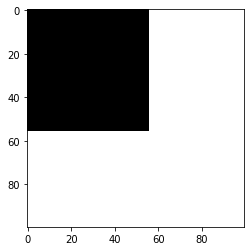

In [6]:
# Podemos ver una de las imágenes creadas para ver qué pinta tiene

# Fijamos un índice cualquiera
num_img = 56

img_visual = input_data[num_img]
plt.imshow(img_visual.reshape(img_visual.shape[:2]),cmap='gray')

A continuación definimos nuestra red _autoencoder_ con la API funcional de keras. Vamos a definir primero el _encoder_ y luego el _decoder_. Cuando estén definidas uniremos las dos redes. Esto se puede hacer muy fácilmente usando la API funcional de keras. Ambas redes tienen la arquitectura conocida de apilamiento de capas que ya hemos visto anteriormente. Usan capas convolucionales, densas, _flatten_ y maxpooling. La única capa nueva que vamos a usar en este experimento es _Upsampling_, que duplica las filas y columnas de píxeles. Del mismo modo que las capas de _pooling_ disminuyen el tamaño de las imágenes, las capas _UpSampling_ aumentan el tamaño y se usan en los autoencoders para restaurar el tamaño de la imagen original a partir del espacio latente.

Definimos primero el _encoder_

In [7]:
# Fijamos el valor de la dimensión del espacio latente
dim_espacio_latente = 1

In [8]:
# Definimos el encoder 
input_img = Input(shape=(mi_lado, mi_lado, 1))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# Guardo el tamaño antes de aplanar, para recuperarlo
# en el decodificador
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x) 
encoder_output= Dense(dim_espacio_latente,name='encoder_output')(x) 

encoder_1 = Model(input_img, encoder_output)

In [9]:
# Vemos un resumen de la red que hemos creado
encoder_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 4)         292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1)                 2501      
Total para

No deja de ser una red simple con dos capas de convolución, dos MaxPooling, una para aplanar la imágenes y una capa final densa con una única neurona de salida.

In [10]:
# Definimos el decoder
decoder_input= Input((dim_espacio_latente,))
x = Dense(np.prod(shape_before_flattening),activation='relu')(decoder_input) #(2)
x = Reshape(shape_before_flattening)(x) 
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_1 = Model(decoder_input, decoded)

Vemos la estructura de la red decoder

In [11]:
decoder_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2500)              5000      
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 4)         148       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 8)         296       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 100, 100, 8)       0         
__________

Fíjate que la aplicación de la capa _upsampling_ duplica de tamaño del lado de la imagen. Con la API funcional de keras podemos fácilmente unir las dos redes

In [12]:
# Definimos la entrada del autoencoder
autoencoder_1_input = Input(shape=(mi_lado, mi_lado, 1))
# Definimos la salida del encoder
encoded_1 = encoder_1(autoencoder_1_input)
# Definimos la salida del decoder
decoded_1 = decoder_1(encoded_1)
# Creamos el autoencoder enlazando la entrada con la salida que queremos
autoencoder_1 = Model(autoencoder_1_input, decoded_1)

Podemos representar el esquema del autoencoder. No nos da mucha información, pero podemos ver que el número de parámetros entrenables es la suma de los del encoder y los del decoder (2873 + 5517 = 8390)

In [13]:
autoencoder_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 2873      
_________________________________________________________________
model_2 (Model)              (None, 100, 100, 1)       5517      
Total params: 8,390
Trainable params: 8,390
Non-trainable params: 0
_________________________________________________________________


Compilamos. Elegimos como medida de error el _error cuadrático medio_.

In [14]:
autoencoder_1.compile(optimizer=Adam(), loss = 'mean_squared_error')

Entrenamos la red. Fíjate que usamos el mismo conjunto de datos para la entrada que para la salida de la red.

In [15]:
history_1 = autoencoder_1.fit(x=input_data, 
                              y=input_data, 
                              batch_size=20, 
                              shuffle=True, 
                              epochs=500)

Epoch 1/500
100/100 [==============================] - 11s 106ms/step - loss: 0.2491
Epoch 2/500
100/100 [==============================] - 0s 2ms/step - loss: 0.2436
Epoch 3/500
100/100 [==============================] - 0s 2ms/step - loss: 0.2315
Epoch 4/500
100/100 [==============================] - 0s 2ms/step - loss: 0.2048
Epoch 5/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1790
Epoch 6/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1708
Epoch 7/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1611
Epoch 8/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1481
Epoch 9/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1408
Epoch 10/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1339
Epoch 11/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1283
Epoch 12/500
100/100 [==============================] - 0s 2ms/step - loss: 0.1253
Epoch 13/5

100/100 [==============================] - 0s 2ms/step - loss: 0.0571
Epoch 100/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 101/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 102/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 103/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0556
Epoch 104/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0552
Epoch 105/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0550
Epoch 106/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0545
Epoch 107/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0542
Epoch 108/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0540
Epoch 109/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0538
Epoch 110/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 

100/100 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 197/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 198/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 199/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 200/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 201/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 202/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 203/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 204/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 205/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 206/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 207/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 

100/100 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 294/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 295/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 296/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 297/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 298/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 299/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 300/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 301/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 302/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 303/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 304/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 

100/100 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 391/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 392/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 393/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 394/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 395/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 396/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 397/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 398/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 399/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 400/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 401/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 

100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 488/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 489/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 490/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 491/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 492/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 493/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 494/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 495/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 496/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 497/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 498/500
100/100 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 

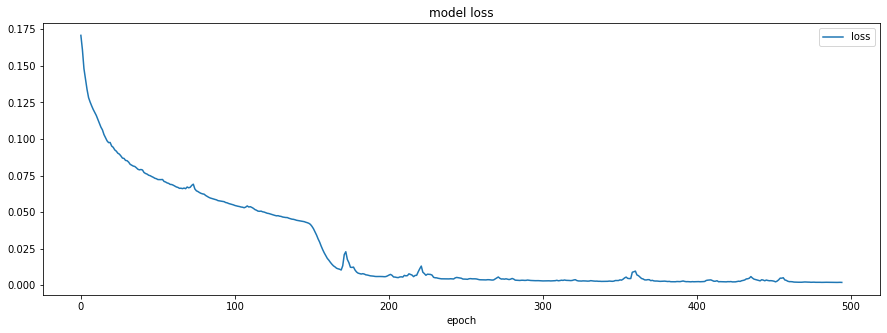

In [16]:
# Vemos cómo ha ido el entrenamiento

start_plot = 5

mpl.rcParams['figure.figsize'] = (15,5)
plt.plot(history_1.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

Vamos a dibujar algunas de las imágenes originales junto a las que devuelve la red para comparar si la red ha sido capaz de restaurarlas correctamente. Hacemos uso de la siguiente función.

In [17]:
def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [18]:
# Con mini y maxi fijamos el intervalo de índices de las imagenes que queremos comparar
mini = 51
maxi = 60

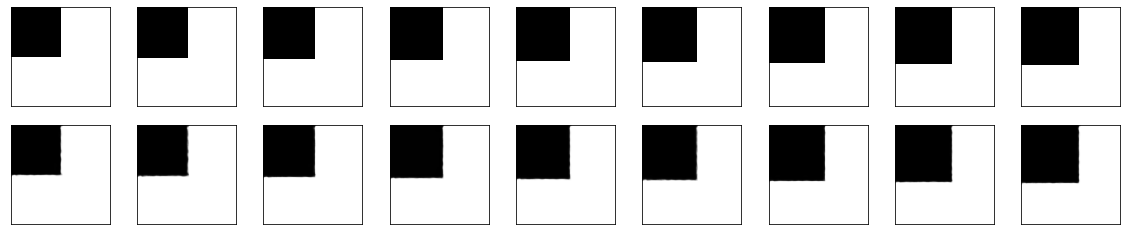

In [19]:
# Calculamos la salida del autoencoder para las imágenes de ese intervalo
decoded_imgs = autoencoder_1.predict(input_data[mini:maxi])

# Dibujamos las imágenes
draw2compare(input_data[mini:maxi], decoded_imgs)

No está mal, teniendo en cuenta que la imagen inferior ha sido creada a partir de un vector del espacio latente con un unico número que codifical la imagen superior.

Puesto que cada una de las imágenes de entrada ha sido codificada por un único número, podemos preguntarnos cuál es ese número que codifica a cada imagen. Para ello, basta ver qué salida da el codficador a partir de las imágenes de entrada.

In [20]:
latente_1 = encoder_1.predict(input_data)

# Vemos los 5 primeros valores
latente_1[:5]

array([[-161.5837 ],
       [-161.4888 ],
       [-161.25012],
       [-160.84444],
       [-159.90852]], dtype=float32)

Nos podemos hacer mejor una idea de ese espacio latente con una representación gráfica.

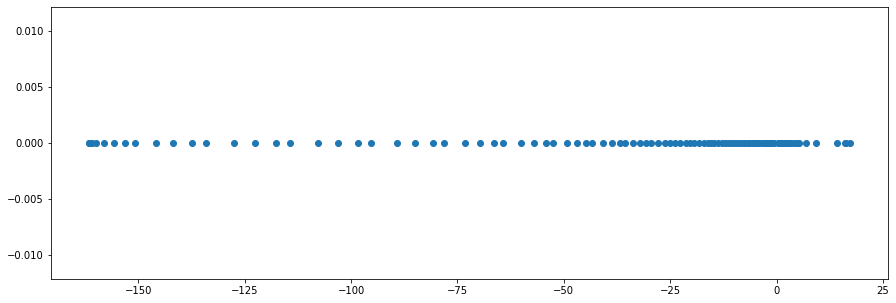

In [21]:
mpl.rcParams['figure.figsize'] = (15,5)
plt.scatter(latente_1,[0]*len(latente_1))
plt.show()

Quizá nos podamos hacer una mejor idea del espacio de latencia con el histograma

(0.0, 30.0)

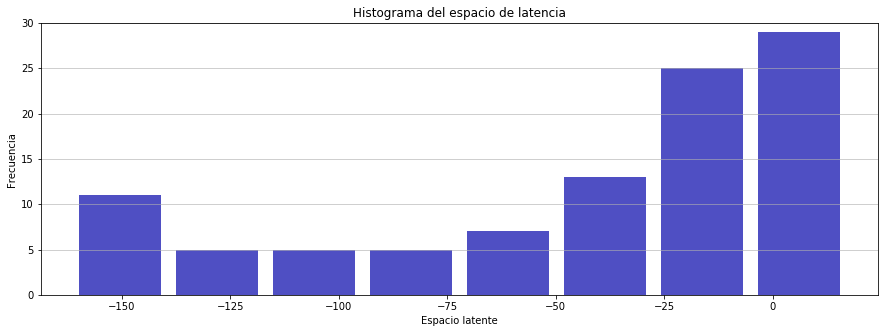

In [22]:
n, bins, patches = plt.hist(x=latente_1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Espacio latente')
plt.ylabel('Frecuencia')
plt.title('Histograma del espacio de latencia')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

Podemos usar el decodificador para generar una imagen concreta a partir de su codificación en el espacio latente.

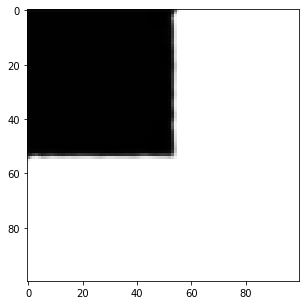

In [23]:
num_decod = 54

imagen_sal_1 = decoder_1.predict(latente_1[num_decod])
plt.imshow(imagen_sal_1.reshape(imagen_sal_1.shape[1:3]),cmap='gray')

El uso de los autoencoders puede extenderse más allá de decodificar los datos de codificación. ¿Qué imagen se genera si proporcionamos como dato de entrada del **decodificador** un valor arbitrario entre 0 y 1 que no sea el que codifica una de las imágenes de entrada?

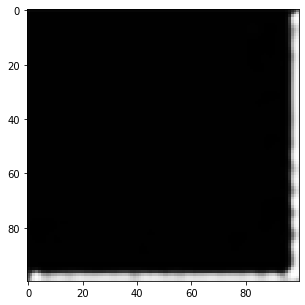

In [24]:
# Tomamos un valor aleatorio entre 0 y 1
nuevo_1 = np.random.rand(1).astype('float32')

# Vemos el resultado de su decodificación
imagen_sal_2 = decoder_1.predict(nuevo_1)
plt.imshow(imagen_sal_2.reshape(imagen_sal_2.shape[1:3]),cmap='gray')

El resultado es _parecido_ a los datos de entrada, aunque, en cierto sentido es una figura _nueva_.

# Experimento 2

El experimento anterior nos ha servido para fijar ideas, pero podemos hacer algo más interesante que codficar cuadrados.

En este segundo experimento vamos a usar el conjunto de datos MNIST. Vamos a entrenar nuestro autoencoder para que aprenda una representación de cada dígito en un espacio bidimensional y después visualizaremos las representaciones aprendidas en un gráfico 2D.

Puesto que los autoencoders tiene una estructura bien definida, podemos crear una clase python para que nos facilite su creación. El objertivo es crear autoencoders como instancias concretas de la clase _Autoencoder_ simplemente especificando algunos parámetros, por ejemplo:

```
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_filters = [64,64,32,1]
    , decoder_conv_kernel_size = [3,3,3,3]
    , decoder_conv_strides = [1,2,2,1]
    , z_dim = 2)
```

Vamos a empezar viendo el código de creación del codificador. La idea fundamental del siguiente código es que el usuario proporciona los parámetros y el valor de la variable x se va actualizando con un bucle _for_ en lugar de dar una estructura fija como en el experimento anterior. La función de activación en este caso es una variante de la ReLU, llamada LeakyReLU. Más información en https://keras.io/layers/advanced-activations/

Vemos primero una definición de la clase que sólo incluye el codificador, luego daremos una versión completa.

In [25]:
class Autoencoder:
    
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_filters, decoder_conv_kernel_size, decoder_conv_strides, z_dim):
        # Los siete parámetros siguientes los definimos para cada instancia de la clase
        # No hay valores predefinidos
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides
        self.z_dim = z_dim
        
        self.encoder = self.__create_encoder()
        
    def __create_encoder(self):
        # En primer lugar fijamos la entrada con el tamaño proporcionado por el usuario
        # En nuestro caso la entrada va a ser una imagen
        encoder_input = Input(shape=self.input_dim, name='encoder_input')
        x = encoder_input
        for i in range(len(self.encoder_conv_filters)):
            # Añadimos capas convolutivas y funciones de activación LeakyReLU secuencialmente
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernel_size[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                name = 'encoder_conv_' + str(i)
            )
 
            x = conv_layer(x) #(2)
            x = LeakyReLU()(x)
        # Guardamos en la variable 'shape_before_flattening'
        # el tamaño del tensor obtenido antes de aplanarlo
        shape_before_flattening = K.int_shape(x)[1:]
        # Aplanamos para ajustar los datos a un vector denso
        x = Flatten()(x) #(3)
        # Finalmente, añadimos una capa densa con tantas neuronas 
        # como haya proporcionado el usuario en los parámetros de entrada
        encoder_output= Dense(self.z_dim, name='encoder_output')(x) #(4)
        # Finalmente, creamos el modelo que toma como entrada la imagen
        # y devuelve el vector latente.
        return Model(encoder_input, encoder_output) #(5)

Vamos a crear una primera instancia de la clase:

In [26]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_filters = [64,64,32,1]
    , decoder_conv_kernel_size = [3,3,3,3]
    , decoder_conv_strides = [1,2,2,1]
    , z_dim = 2)

# Vemos el resumen
AE.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

Podemos cambiar el número de capas convolucionales simplemente añadiendo elementos a las listas. **Se recomienda experimentar con los parámetros para entender mejor como afecta la arquitectura al número de parámetros de cada capa, el rendimiento del modelo y los tiempos de entrenamiento.**

Continuamos ahora con el decodificador. Podemos imaginarlo como un *espejo* del codificador excepto por el tipo de capas convolucionales, aunque en realidad, podemos definirlo como queramos. El decodificador tendrá que transformar el vector latente *z* en una imagen. Para ello usaremos tambien capas de tipo convolucional para obtener dicha imagen.

En este caso vamos a usar una nuevo tipo de capas _Conv2DTranspose_. Sin entrar en detalles, esta capa puede verse como el efecto de una capa de convolución y una capa upsampling en una única capa. Más información en https://arxiv.org/abs/1603.07285. La acción de una capa _Conv2DTranspose_ puede verse en el siguiente esquema.

<img src='img/conv_transposed.gif' />

En Keras tenemos la clase `Conv2DTranspose` que define la funcionalidad de esta capa.

Aunque hemos dicho que el decodificador suele ser una imagen espejo del codificador, no tiene porqué ser así. El decodificador puede tener cualquier estructura pero siempre debe cumplir la condición de que su salida debe tener las misma dimensiones que la entrada del codificador. Esta condición es necesaria para poder definir la función de coste comparando la entrada del codificador con la salida del decodificador.

Vamos ahora a añadir el método de creación del decodificador a nuestra clase `Autoencoder`:

In [27]:
class Autoencoder:
    
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_filters, decoder_conv_kernel_size, decoder_conv_strides, activation, z_dim,
                 use_batch_normalization=False, dropout = None):
    
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides
        self.z_dim = z_dim
        self.activation = activation
        self.use_batch_normalization = use_batch_normalization
        self.dropout = dropout
        
        # Esta parte está modificada para enlazar el codificador y el decodificador
        self.encoder, encoder_input, encoder_output = self.__create_encoder() 
        self.decoder = self.__create_decoder()
        self.model = Model(encoder_input, self.decoder(encoder_output))
        
    def __create_encoder(self):

        encoder_input = Input(shape=self.input_dim, name='encoder_input') 
        x = encoder_input
        for i in range(len(self.encoder_conv_filters)):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernel_size[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                activation = self.activation if isinstance(self.activation, str) else None,
                name = 'encoder_conv_' + str(i)
            )
 
            x = conv_layer(x)
            
            # Si el usuario ha definido una función de activación específica
            # para la última capa la ponemos. Para ver si la ha definido o no usamos
            # inspect. Más información en https://docs.python.org/3/library/inspect.html   
            if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                x = self.activation()(x)
            # Si el usuario ha marcado el uso de BatchNormalization, lo incluimos    
            if self.use_batch_normalization:
                x = BatchNormalization()(x)
            # Si hay Dropout, lo incluimos
            if self.dropout:
                x = Dropout(self.dropout)(x)                

        # Nos guardamos el tamaño antes de aplanar y aplanamos        
        self.__shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        
        encoder_output = self._create_latent_vector(encoder_input, x)
        
        return Model(encoder_input, encoder_output), encoder_input, encoder_output #(5)
        
    def _create_latent_vector(self, encoder_input, x):
        encoder_output= Dense(self.z_dim, name='encoder_output')(x) 
        return encoder_output
    
    
    def __create_decoder(self):
        # La entrada del decodificador es un vector del tamaño
        # que hayamos fijado para el vector latente
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        # Conectamos la entrada a una capa densa con tantas neuronas como
        # entradas tenía la capa correspondiente en el codificador antes de aplanar
        x = Dense(np.prod(self.__shape_before_flattening))(decoder_input)
        # Cambiamos el tamaño de la salida de la capa densa y lo adaptamos 
        # para ser la entrada 2Dde una capa convolutiva
        
        x = Reshape(self.__shape_before_flattening)(x) #(3)
        # Creamos las capas Conv2DTranspose y las apilamos
        for i in range(len(self.decoder_conv_filters)):
            activation = self.activation if isinstance(self.activation, str) else None
            conv_layer = Conv2DTranspose(
                filters = self.decoder_conv_filters[i],
                kernel_size = self.decoder_conv_kernel_size[i],
                strides = self.decoder_conv_strides[i],
                padding = 'same',
                activation = activation if i < len(self.decoder_conv_filters)-1 else 'sigmoid',
                name = 'decoder_conv_' + str(i)
            )
 
            x = conv_layer(x) 
            # De manera análoga a lo que ocurría en el codificador, hacemos las
            # comprobaciones y los cambios si son necesarios
            if i < len(self.decoder_conv_filters)-1:
                if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                    x = self.activation()(x)

                if self.use_batch_normalization:
                    x = BatchNormalization()(x)

                if self.dropout:
                    x = Dropout(self.dropout)(x)                
            
            
        decoder_output = x
        # Finalmente, devolvemos el decodificador que toma como entrada
        # el vector latente y devuelve una imagen del mismo tamaño que las imágenes de entrada
        return Model(decoder_input, decoder_output)

Vamos a probarlo. Definimos una instancia concreta de la clase.

In [125]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_filters = [64,64,32,1]
    , decoder_conv_kernel_size = [3,3,3,3]
    , decoder_conv_strides = [1,2,2,1]
    , activation = 'relu'
    , z_dim = 2)

# Vemos la estructura del decodificador
AE.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_conv_3 (Conv2DTransp (None, 28, 28, 1)         289       
Total para

Para poder entrenar el autoencoder debemos unir el codificador y del decodificador. Para ello, como has visto, hemos modificador el método `__init__` en sus última líneas:

```
        self.encoder, encoder_input, encoder_output = self.__create_encoder() #(1)
        self.decoder = self.__create_decoder()                                
        self.model = Model(encoder_input, self.decoder(encoder_output))       #(2) 
```

   1. La entrada del autoencoder será la misma que la entrada del codificador. Además la salida del codificador será la entrada decodificador. Hemos modificador el método `__create_encoder` para que nos devuelva esos tensores.
   2. Creamos el modelo Keras del autoencoder cuya entrada, como ya hemos dicho, es la entrada del codificador y su salida es la salida que dará el decodificador al darle como entrada al salida del codificador.

Vemos un esquema del modelo generado en la instancia AE de la clase autoencoder que hemos generado.

In [126]:
AE.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 6274      
__________

Ahora que ya tenemos nuestro modelo creado, podemos compilarlo usando una optimizador y una función de coste. Respecto a la función de coste tenemos varias opciones. Podemos usar (entre otras):

* MSE, error cuadrático medio (mean squared error)
* RMSE, raíz cuadrada del error cuadrático medio (root mean squared error)
* binary cross entropy
* SSIM (similaridad estructural). Más información en https://en.wikipedia.org/wiki/Structural_similarity

La función de coste *binary cross entropy* realiza una comparación pixel a pixel entre la imagen original y la reconstruida penalizando mucho las malas predicciones, lo que hace que la red tienda a predecir el punto medio del rango. Esto da lugar a imágenes muy claras (con mucho gris). 

En nuestro caso usaremos MSE como función de coste y SSIM como métrica. Es recomendable **probar binary cross entropy y SSIM como funciones de coste para ver su efecto**. 

In [30]:
# Definimos la métrica ssim_loss a partir de la función
# ssim del módulo image de tensorflow

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

Ahora compilamos el modelo con el optimizador Adam y el error cuadrático medio como función de error

In [127]:
AE.model.compile(optimizer=Adam(), loss = 'mse', metrics=[ssim_loss])

El último paso es entrenar nuestra autoencoder. Para ello necesitamos el conjunto de datos MNIST que viene con keras.

In [128]:
# Cargamos el dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Preprocesamos las imágenes
image_size = x_train_mnist.shape[1]
x_train_mnist = np.reshape(x_train_mnist, [-1, image_size, image_size, 1])
x_test_mnist = np.reshape(x_test_mnist, [-1, image_size, image_size, 1])
x_train_mnist = x_train_mnist.astype('float32') / 255
x_test_mnist = x_test_mnist.astype('float32') / 255

Ahora entrenamos el modelo. Usamos _PlotLossesKeras()_ para visualizar las métricas de manera dinámica y no tener que esperar al final del entrenamiento para verlas.

In [129]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
AE.model.load_weights('AE_mnist_weights.h5')

In [34]:
AE.model.fit(x=x_train_mnist, y=x_train_mnist, 
             validation_data=(x_test_mnist, x_test_mnist),
             batch_size=128, shuffle=True, epochs=50,
             callbacks=[PlotLossesKeras()])

In [35]:
# Si no lo hemos hecho antes, podemos
# guardar los pesos de la red una vez entrenada
AE.model.save_weights('AE_mnist_weights.h5')

## Visualizando la reconstrucción

Ahora que tenemos el autoencoder entrenado podemos comparar las imágenes de entrada y su reconstrucción, como hemos hecho antes en el experimento 1.

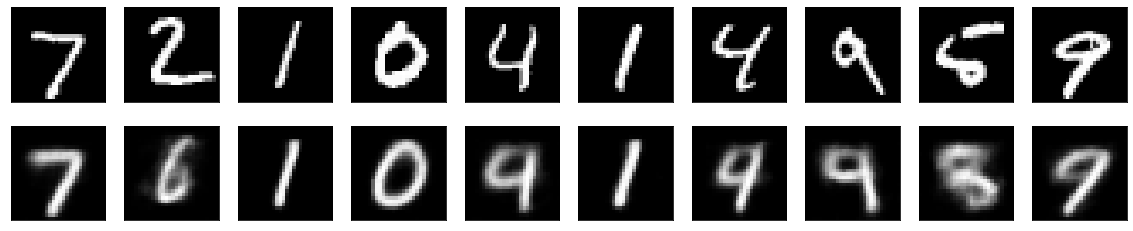

In [36]:
n = 10
decoded_imgs_mnist = AE.model.predict(x_test_mnist[:n])

draw2compare(x_test_mnist[:n], decoded_imgs_mnist)

Aquí vemos algunas cosas interesantes (los comentarios corresponden a la ejecución en mi ordenador, los resultados pueden cambiar debido a la aleatoriedad del proceso):
   1. El 2 tiene una pobre reconstrucción. No es algo preocupante. Estamos usando una vector latente de 2D para llevar a cabo la visualización del espacio latente. **Se recomienda entrenar al autoencoder con un vector de mayor dimensión y ver la mejora en la reconstrucción**.
   2. Uno de los "nueve" aparece rotado. Parece que el vector latente tiene información sobre el digito, pero no de su ángulo.
   3. El 5 lo reconstruye como un 8, y los cuatro tienden a ser 9. 

## Visualizando el espacio latente

Para visualizar el espacio latente solo tenemos que pasar las imágenes por el codificador. A cada imagen le corresponde un vector de dos dimensiones que podemos representar como un punto en el plano. Como tenemos identificado que dígito es cada imagen, lo usaremos para identificar cada punto con un color:

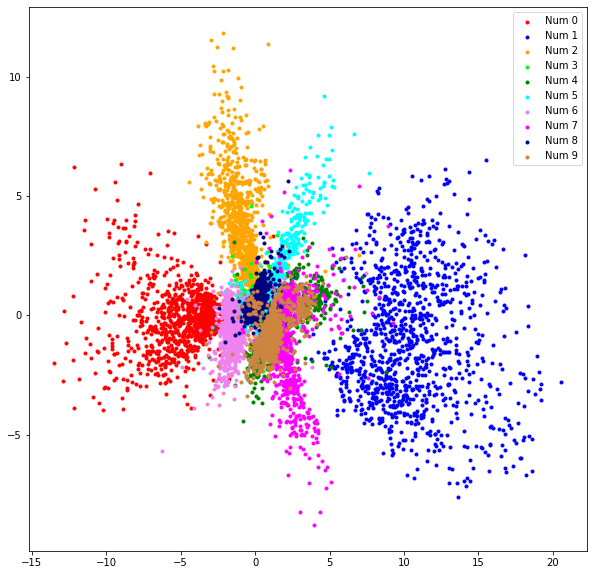

In [130]:
z_points_ae = AE.encoder.predict(x_test_mnist)

# Elegimos los colores con que vamos a representar cada número
colores = ['red','blue','orange','lime','green','cyan','violet','fuchsia','navy','peru']

for i in range(10):
    Xs_i = [z_points_ae[:,0][k] for k in range(len(z_points_ae)) if y_test_mnist[k] == i]
    Ys_i = [z_points_ae[:,1][k] for k in range(len(z_points_ae)) if y_test_mnist[k] == i]
    plt.scatter(Xs_i,Ys_i,c=colores[i],marker='.',label='Num '+str(i))

mpl.rcParams['figure.figsize'] = (10,10) # Para el tamaño de la imagen
plt.legend()
plt.show()

También podemos obtener esta representación mediante la función _kdeplot_ del paquete _seaborn_ que además de representar los puntos nos da información de la densidad en cada uno de los ejes.

In [38]:
def show_latent_space(M, X, highlight=None):
    latent_vectors = M.encoder.predict(X)
    data = pd.DataFrame({'x': latent_vectors[:,0], 
                         'y': latent_vectors[:,1],
                         'number': y_test_mnist})
    data['number'] = data.number.map(lambda x: 'number %d ' % x)
    data['size'] = 0.1
    data['sample'] = 1

    if highlight is not None:
        hl_data = pd.DataFrame({'x': highlight[:,0], 
                                'y': highlight[:,1],
                                'number': 'hl',
                                'size': 3})
        data = pd.concat((data, hl_data), axis=0, sort=False)

    grid = sns.JointGrid(x='x', y='y', data=data) 
    g = grid.plot_joint(sns.scatterplot, hue='number', size='size', data=data, legend=False)

    sns.kdeplot(data.x, ax=g.ax_marg_x, legend=False, color='r', shade=True)
    sns.kdeplot(data.y, ax=g.ax_marg_y, vertical=True, legend=False, color='r', shade=True)

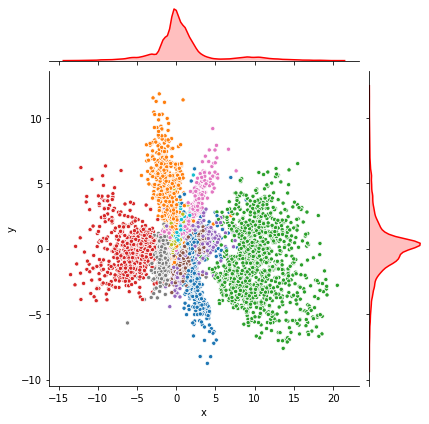

In [39]:
# Aplicamos la función
show_latent_space(AE, x_test_mnist)

Vemos que la distribución es muy irregular y ocupa una región del plano muy amplia. En general es un tema de investigación el estudio de distribución de puntos en un espacio latente n-dimensional


## Muestreando el espacio latente

Igual que vimos en el experimento 1, también podemos preguntarnos por la generación de imágenes a partir de puntos del espacio latente que no corresponden a imaǵenes de entrada.

Vamos a generar puntos del espacio latente y vamos a ver qué imágenes podemos reconstruir a a partir de ellos.

In [40]:
# Usaremos esta función para numerar los vértices 
# y referirnos a uno en concreto

def numera_vertices(v):
    margen = 0.08
    for i in range(v.shape[0]):
        plt.text(v[i][0]+margen,v[i][1]+margen,str(i),fontsize = 12)   

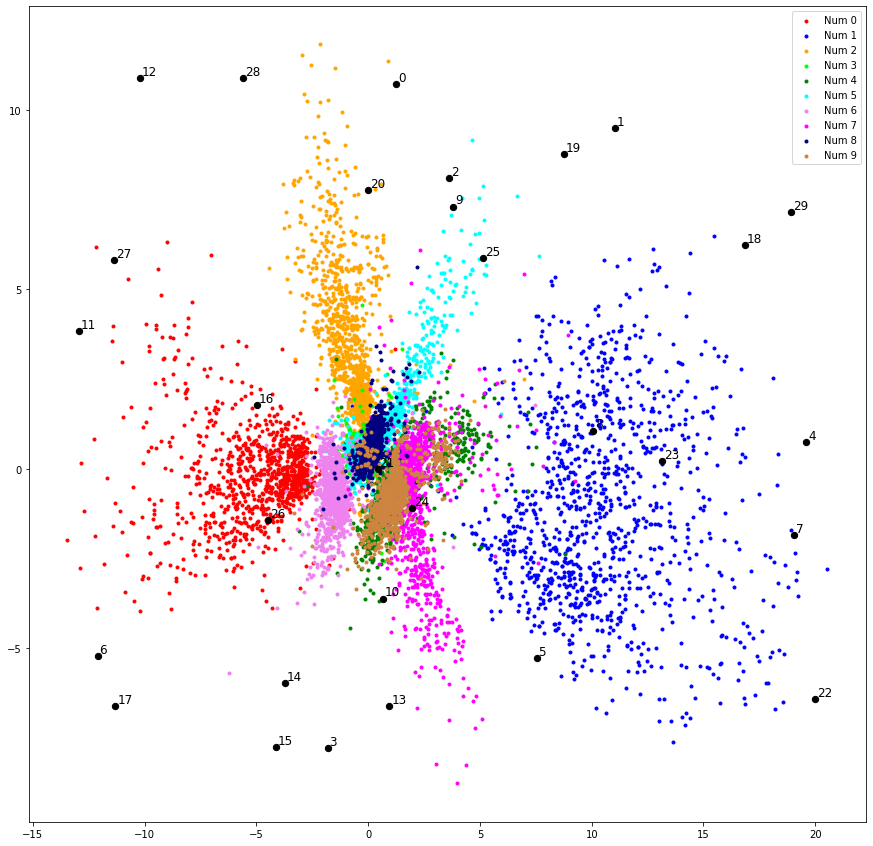

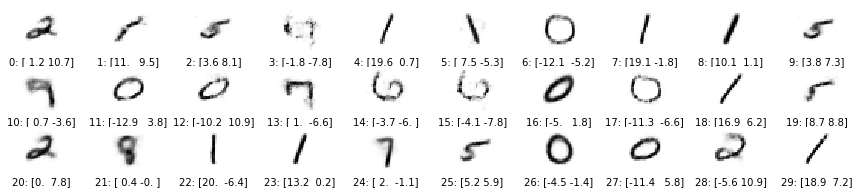

In [41]:
# Fijamos el tamaño de la imagen
figsize = 15

# Fijamos los intervalos donde vamos a tomar valores aleatorios
min_x = min(z_points_ae[:, 0])
max_x = max(z_points_ae[:, 0])
min_y = min(z_points_ae[:, 1])
max_y = max(z_points_ae[:, 1])


# Dibujamos los puntos del espacio latente
plt.figure(figsize=(figsize, figsize))

for i in range(10):
    Xs_i = [z_points_ae[:,0][k] for k in range(len(z_points_ae)) if y_test_mnist[k] == i]
    Ys_i = [z_points_ae[:,1][k] for k in range(len(z_points_ae)) if y_test_mnist[k] == i]
    plt.scatter(Xs_i,Ys_i,c=colores[i],marker='.',label='Num '+str(i))
        
# Fijamos el número de puntos aleatorios que vamos a generar    
num_puntos = 30
    
# Generamos los puntos del espacio latente    
grid_size = 10
grid_depth = 3

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)

# Computamos la decodificación de esos puntos
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

# Numeramos os puntos para hacerles un seguimiento
numera_vertices(z_grid)

# Coloreamos en negro los puntos aleatorios del espacio latente
plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black', alpha=1, s=40)
plt.legend()
plt.show()

# Vamos a dibujar la imagen generada representada junto al punto 2D que la produce
fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i) + ': ' +str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

Podemos repetir un estudio análogo usando la librería _seaborn_ para la representación gráfica.

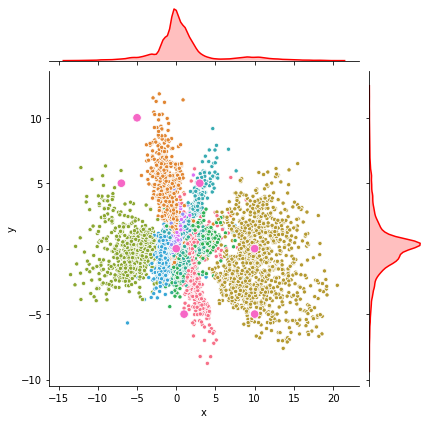

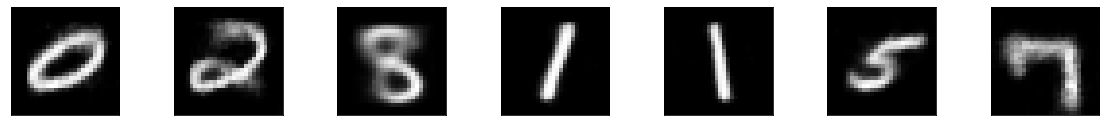

In [42]:
# creamos una lista de vectores (puntos en nuevo espacio latente)
vectors = np.array([[-7, 5], [-5, 10], [0,0], [10, 0], [10, -5], [3, 5], [1, -5]])

# mostramos el espacio latente resaltando los puntos que hemos muestreado
show_latent_space(AE, x_test_mnist, vectors)

# usamos el decodificador para obtener la imágenes reconstruidas a partir de los vectores
decoded_imgs_ae = AE.decoder.predict(vectors)
draw2compare(decoded_imgs_ae)

De manera similar podemos crear una visualización del espacio latente representando la imagen codificada en lugar del punto 2D. Esto nos puede dar una mejor intuición de como se distribuye nuestro espacio latente. Para ello, vamos a crear primero un grid de puntos equiespaciados en una región del espacio y asociaremos una imagen a cada punto del grid. Para ello usamos la siguiente función:

In [43]:
def sample_latent_space(M, x_range, y_range, n=30):
    # número de imágenes por fila y columna (total de imágenes nxn)
    im_size = M.decoder.layers[-1].output_shape[1]

    # creamos una matriz donde iremos pegando cada dígito generado
    figure = np.zeros((im_size * n, im_size * n))

    # generamos coordenadas linearmente espaciadas usando los
    # máximo y mínimos de nuestro espacio latente
    grid_x = np.linspace(x_range[0], x_range[1], n)
    grid_y = np.linspace(y_range[0], y_range[1], n)
    
    z_pts = M.encoder.predict(x_test_mnist)
        
    for i in range(10):
        Xs_i = [z_pts[:,0][k] for k in range(len(z_pts)) if y_test_mnist[k] == i]
        Ys_i = [z_pts[:,1][k] for k in range(len(z_pts)) if y_test_mnist[k] == i]
        plt.scatter(Xs_i,Ys_i,c=colores[i],marker='.',label='Num '+str(i))
    
    # coloreamos en negro los puntos aleatorios del espacio latente
    for i in grid_x:
        plt.scatter([i]*len(grid_x) , grid_y, c = 'black', alpha=1, s=10)
    plt.legend()
    plt.show()    
    
    print('\nRepresentamos ahora la imagen asociada a cada uno de los puntos del grid \n')
    
    
    # recorremos las coordenadas y por cada par obtenemos
    # la reconstrucción y la agregamos la matirz
    k = 0
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            digit = M.decoder.predict(np.array([[xi, yi]]))[0].reshape((im_size, im_size))
            figure[i * im_size: (i + 1) * im_size,
                   j * im_size: (j + 1) * im_size] = digit
            k += 1

    plt.figure(figsize=(16, 16))
    plt.imshow(figure, cmap='Greys_r',extent=[x_range[0],x_range[1],y_range[0],y_range[1]])
    plt.show()

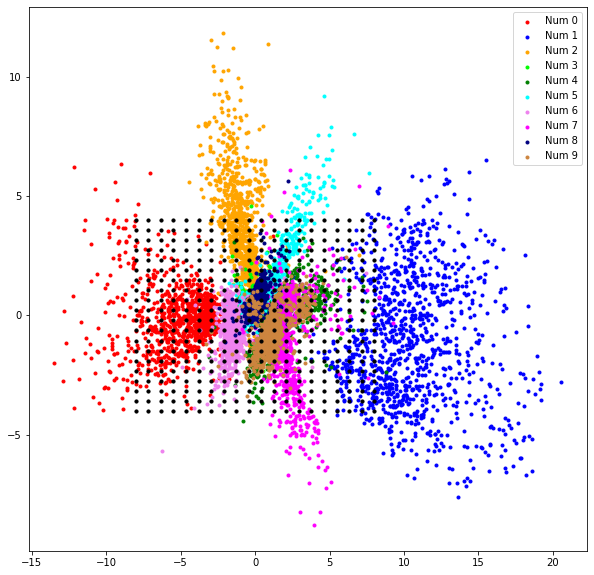


Representamos ahora la imagen asociada a cada uno de los puntos del grid 



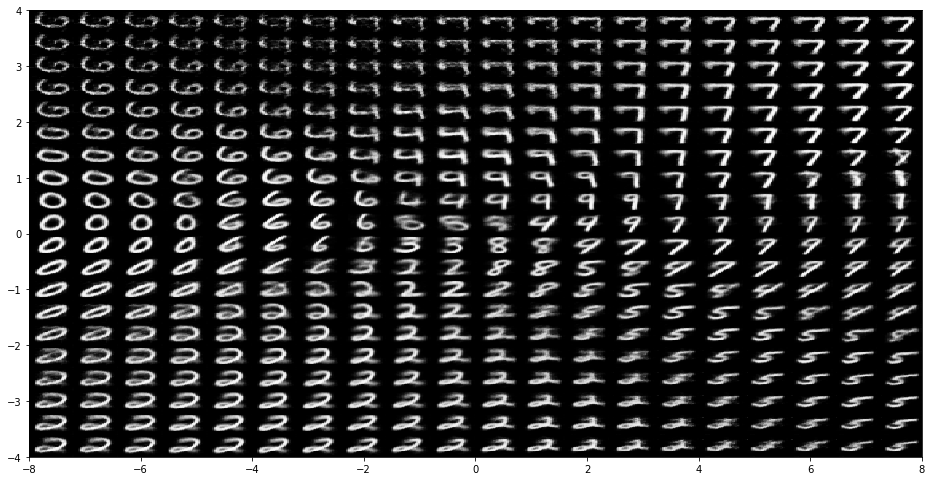

In [44]:
# Acotamos ahora una región del plano, distribuimos los puntos de manera
# uniforme y generamos las imágenes asociadas a esos puntos.
# Esto nos da una idea de la distribución de imágenes por el espacio latente.

sample_latent_space(AE, (-8, 8), (-4, 4), n=20)

Como vemos hay gran cantidad de imagenes que no parecen dígítos. Esto es debido a que hemos hecho una barrido lineal, lo que nos habrá llevado a muchas zonas vacías del espacio latente que no tienen ninguna representación cercana en el conjunto de entrenamiento. 

# Experimento 3:

## Denoising autoencoders 

Los *denoising autoencoders* o autoencoders para eliminación/reducción de ruido son una aplicación particular de los autoencoders. Desde el punto de vista de la estructura de la red no tienen nada de particular. Lo único que tienen de especial es el modo de entrenamiento, en concreto, los datos de entrada. Así que vamos a crear nuestra red como en el ejemplo anterior:

In [45]:
# Nos aseguramos de tener limpia la sesión de tensorflow
K.clear_session()

In [46]:
DAE_MNIST = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_filters = [64,64,32,1]
    , decoder_conv_kernel_size = [3,3,3,3]
    , decoder_conv_strides = [1,2,2,1]
    , activation = 'relu'
    , z_dim = 16)

DAE_MNIST.model.compile(optimizer=Adam(), loss = 'mean_squared_error', metrics=[ssim_loss])

Igual que antes, vamos a seguir jugando con datos de los que no tenemos etiquetas asociadas a las muestras (o al menos no las vamos a usar en la fase de entrenamiento). Lo que cambia en esta aplicación es que vamos a aplicar una distorsión a la imagen de entrada, pero la imagen que esperamos que reconstruya será la imagen limpia:

<img src='img/noise_reduction.svg' width='70%'>

Vamos a seguir con el conjunto de datos MNIST. En primer lugar vamos a definir una función para agregar ruido a un conjunto de datos:

In [47]:
def add_noise(data, center=0.5, std=0.5, hard=False):
    # ruido usando una distribución normal centrada en 0.5 y con std 0.5
    noise = np.random.normal(loc=0.5, scale=std, size=data.shape)
    # La opción "hard" introduce
    # mucho más ruido
    if hard:
        return np.clip(data + noise, 0., 1.)
    else:
        img2 = data*2
        n4 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.4)), (1-img2+1)*(1 + noise*0.4)*-1 + 2)/2, 0,1)
        return n4

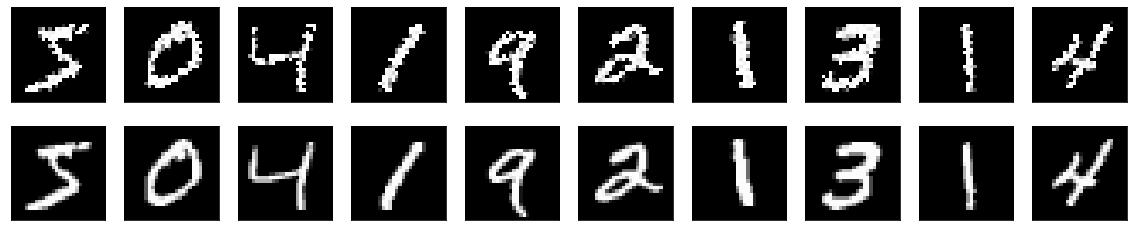

In [48]:
# Comparamos las imágenes con ruido y las originales
x_train_noisy = add_noise(x_train_mnist,center= 20.0,std=12.0)
draw2compare(x_train_noisy[:10], x_train_mnist[:10])

# Si queremos probar con ruido "hard"
#draw2compare(add_noise(x_test_mnist[:10], hard=True), x_test_mnist[:10])

Es una función muy sencilla que agrega un ruido aleatorio usando una distribución normal. Se puede apreciar que las imágenes son bastante ruidosas. 

A la hora de entrenar le daremos a la red las imágenes de la primera fila y para computar el error cometido le daremos las imágenes de segunda fila.

In [49]:
# Añadimos ruido al conjunto de test
x_test_noisy = add_noise(x_test_mnist,center= 20.0,std=12.0)

In [50]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
DAE_MNIST.model.load_weights('dae_mnist_weights.h5')

Entrenmos el modelo

In [51]:
DAE_MNIST.model.fit(x=x_train_noisy, y=x_train_mnist, 
             validation_data=(x_test_noisy, x_test_mnist),
             batch_size=128, shuffle=True, epochs=50,
             callbacks=[PlotLossesKeras()])

In [52]:
# Guardamos los pesos después del entrenamiento
DAE_MNIST.model.save_weights('dae_mnist_weights.h5')

En la vida real es difícil medir la calidad de un reductor de ruido, ya que obviamente, no tenemos la imagen original para comparar. Es este caso, sí podemos medirla. Vamos a comparar con el error cuadrático medio la distancia entre el original y la imagen con ruido y por otra parte el original y la imagen con ruido una vez eliminado el ruido. Para ello vamos a usar la siguiente función:

In [53]:
def mse_compara(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

Comparamos

In [54]:
denoise_test_mnist = DAE_MNIST.model.predict(x_test_noisy)

mse_test_mnist_noisy = mse_compara(x_test_noisy, x_test_mnist)
mse_denoise_test_mnist = mse_compara(denoise_test_mnist, x_test_mnist)

print('El error antes de eliminar el ruido era',mse_test_mnist_noisy,
      'y después de quitar el ruido era',mse_denoise_test_mnist)

El error antes de eliminar el ruido era 0.019470148711063024 y después de quitar el ruido era 0.008197974


Podemos ver la calidad de nuestro reductor de ruido sobre algunas imágenes. Añadimos ruido a algunas de las imágenes del conjunto de test y vemos cuál es la salida de nuestro autoencoder. La primera fila contiene imágenes originales, la segunda imágenes con ruido y la tercera las imágenes con ruido una vez limpiadas de ruido.

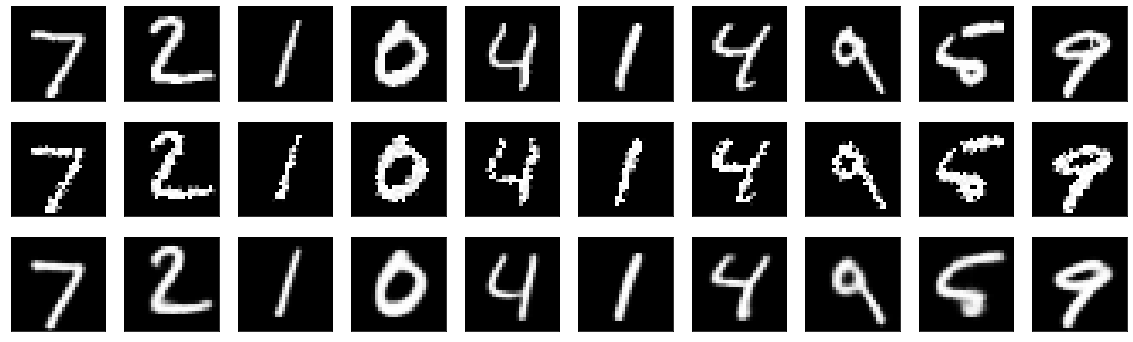

In [55]:
num_mnist = 10

draw2compare(x_test_mnist[:num_mnist], x_test_noisy[:num_mnist],denoise_test_mnist[:num_mnist])

Parece razonablemente efectivo con este conjunto de datos, si el ruido se mantiene dentro de ciertos límites (si hacemos la prueba con el parámetro hard=True) la distorsión es mucho mayor y los resultados no son tan buenos. Pruébalo.

Este experimento lo hemos realizado con MNIST. ¿Y si probamos con un conjunto de datos más complejo?

### Denoising autoencoder con CIFAR10

El conjunto de datoa CIFAR10 esta compuesto por imágenes RGB de tamaño 32x32. Siguen siendo pequeñas, pero al menos vamos a probar con imágenes más complejas y a color.

Al igual que con MNIST solo tenemos que leer el conjunto de datos con Keras y escalar las imágenes a valores entre 0 y 1:

In [56]:
# Antes que nada, nos aseguramos de tener limpia la sesión de tensorflow
K.clear_session()

In [57]:
(x_train_cifar10, _), (x_test_cifar10, _) = cifar10.load_data()

#image_size_cifar10 = x_train_cifar10.shape[1]
x_train_cifar10 = x_train_cifar10.astype('float32') / 255
x_test_cifar10 = x_test_cifar10.astype('float32') / 255

En este caso vamos a aplicar ruido gaussiano centrado en 0 y con desviación típica 0.4:

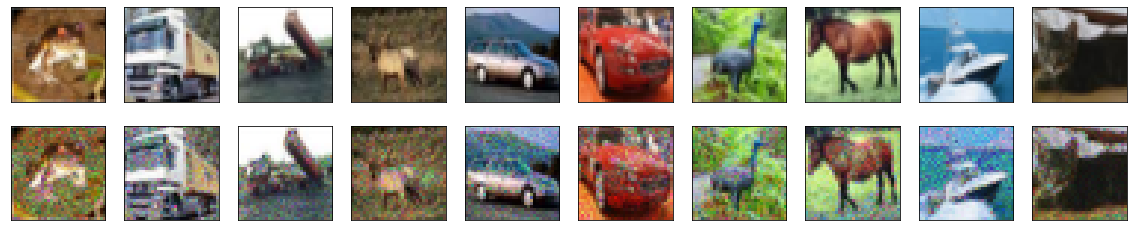

In [58]:
x_train_cifar10_noisy = add_noise(x_train_cifar10, center=0, std=0.4)
x_test_cifar10_noisy = add_noise(x_test_cifar10,center=0, std=0.4)

# Comparamos las 10 primeras imágenes
draw2compare(x_train_cifar10[:10], x_train_cifar10_noisy[:10])

Algunos cambios con respecto al ejemplo con MNIST:
   1. Ahora el decodificador debe generar una imagen con 3 canales (RGB) por lo que la última capa convolucional debe generar 3 mapas (filters = 3). Anteriormente, como eran imágenes en escala de grises, este valor era 1.
   2. El tamaño del vector latente ahora es mucho más grande. Queremos eliminar el ruido, pero no queremos perder excesiva información de la imagen de entrada.
   3. Vamos a reducir el factor de aprendizaje de manera dinámica a lo largo del entrenamiento intorduciendo la función `ReduceLROnPlateau` en los _callbacks_. Esta función implementa una reducción progresiva del _learning rate_ cuando no se produce mejora.
   
Definimos el autoencoder

In [59]:
DAE_CIFAR10 = Autoencoder(
        input_dim = (32,32,3)
        , encoder_conv_filters = [32,64,64,64]
        , encoder_conv_kernel_size = [3,3,3,3]
        , encoder_conv_strides = [1,2,2,1]
        , decoder_conv_filters = [64,64,32,3]
        , decoder_conv_kernel_size = [3,3,3,3]         #(1)
        , decoder_conv_strides = [1,2,2,1]
        , activation = 'relu'
        , z_dim = 1024)                                 #(2)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)   #(3)

DAE_CIFAR10.model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[ssim_loss])

In [60]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
DAE_CIFAR10.model.load_weights('dae_cifar10_weights.h5')

Entrenamos

In [61]:
DAE_CIFAR10.model.fit(x=x_train_cifar10_noisy, y=x_train_cifar10, 
              validation_data=(x_test_cifar10_noisy, x_test_cifar10),
             batch_size=128, shuffle=True, epochs=50,            
             callbacks=[PlotLossesKeras()])

In [62]:
# Si no hemos guardado los pesos, los guadamos ahora
DAE_CIFAR10.model.save_weights('dae_cifar10_weights.h5')

Igual que antes, comparamos con mse para ver si hemos conseguido disminuir el error.

In [63]:
denoise_test_cifar10 = DAE_CIFAR10.model.predict(x_test_cifar10_noisy)

mse_test_cifar10_noisy = mse_compara(x_test_cifar10_noisy, x_test_cifar10)
mse_denoise_test_cifar10 = mse_compara(denoise_test_cifar10, x_test_cifar10)

print('El error antes de eliminar el ruido era',mse_test_cifar10_noisy,
      'y después de quitar el ruido era',mse_denoise_test_cifar10)

El error antes de eliminar el ruido era 0.006721524548411857 y después de quitar el ruido era 0.0028536718


Visualizamos las 10 primeras imágenes

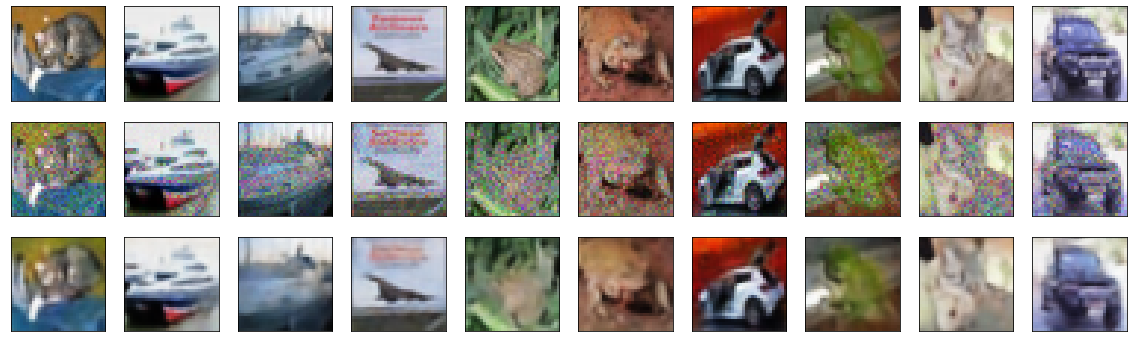

In [64]:
draw2compare(x_test_cifar10[:10], x_test_cifar10_noisy[:10], denoise_test_cifar10[:10])

Antes de pasar al siguiente experimento, puedes visitar https://codahead.com/blog/a-denoising-autoencoder-for-cifar-datasets donde hay una aproximación a este mismo problema con una arquitectura diferente (basada en U-nets).

# Experimento 4:

## Autoencoder para colorear

En esta aplicación vamos a enseñar al autoencoder a colorear imágenes en blanco y negro. El proceso es muy similar al caso anterior. Tomaremos las imágenes de nuestro conjunto de datos y a la entrada le vamos a aplicar una transformación, en este caso la convertiremos a blanco y negro. La salida esperada, que le daremos a la red, será la imagen original con en el caso anterior:

<img src='img/colorization.svg' width='70%' />

Vamos a empezar definiendo la función que pasará nuestras imágenes en color de CIFAR10 a blanco y negro:

In [65]:
def rgb2gray(data):
    # grayscale = 0.299*red + 0.587*green + 0.114*blue
    factors = [0.299, 0.587, 0.114]
    return np.dot(data[...,:3], factors).reshape(list(data.shape[:-1]) + [1])    

Comparamos las imágenes originales y transformadas

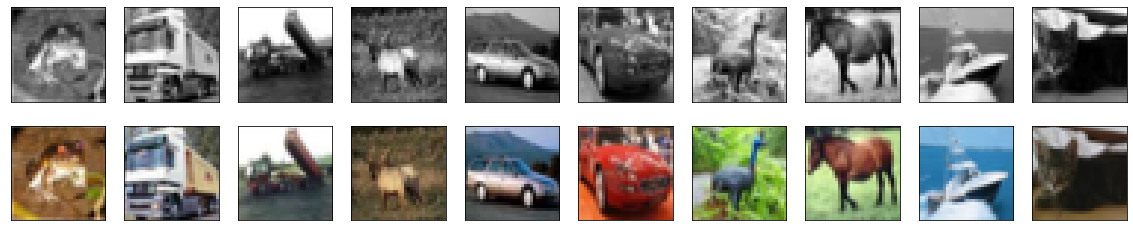

In [66]:
draw2compare(rgb2gray(x_train_cifar10[:10]), x_train_cifar10[:10])

La primera fila son las imágenes de entrada a nuestro autoencoder (en blanco y negro) y la segunda fila la reconstrucción esperada (en color).

In [67]:
# Antes que nada, nos aseguramos de tener limpia la sesión de tensorflow
K.clear_session()

El proceso de entrenamiento es el mismo que en el caso anterior. Únicamente se ha cambiado el punto #(3) donde se transforman los datos que vamos a usar de entrada. Sobre la construcción del autoencoder en #(1) hemos cambiado la dimensión de entrada. Ahora solo tenemos un canal, ya que la entrada es en escala de grises. En #(2) seguimos teniendo 3 canales de salida ya que esperamos la imagen en RGB.

In [68]:
# Creamos las imágenes en blanco y negro
x_train_cifar10_gray = rgb2gray(x_train_cifar10)                    
x_test_cifar10_gray = rgb2gray(x_test_cifar10)

Creamos el autoencoder y compilamos

In [69]:
CAE_CIFAR10 = Autoencoder(
        input_dim = (32,32,1)                          #(1)
        , encoder_conv_filters = [32,64,64,64]
        , encoder_conv_kernel_size = [3,3,3,3]
        , encoder_conv_strides = [1,2,2,1]
        , decoder_conv_filters = [64,64,32,3]
        , decoder_conv_kernel_size = [3,3,3,3]         #(2)
        , decoder_conv_strides = [1,2,2,1]
        , activation = 'relu'
        , z_dim = 1024)                                

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)   

CAE_CIFAR10.model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=[ssim_loss])

In [70]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
CAE_CIFAR10.model.load_weights('cae_cifar10_weights.h5')

Entrenamos

In [71]:
CAE_CIFAR10.model.fit(x=x_train_cifar10_gray, y=x_train_cifar10, 
             validation_data=(x_test_cifar10_gray, x_test_cifar10),
             batch_size=128, shuffle=True, epochs=50,
             callbacks=[PlotLossesKeras()])                      

In [72]:
# Si no los hemos guardado antes, guardamos ahora los pesos
# obtenidos por el entrenamiento

CAE_CIFAR10.model.save_weights('cae_cifar10_weights.h5')

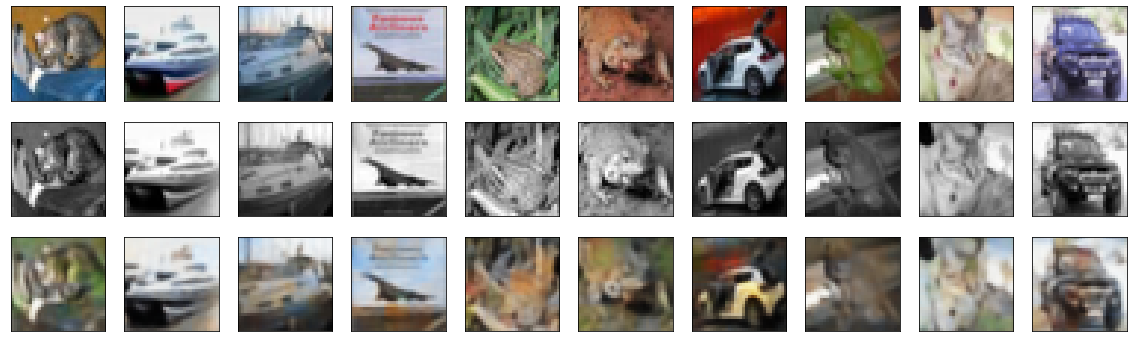

In [73]:
# Comparamos los resultados sobre el conjunto de test

colorized_samples = CAE_CIFAR10.model.predict(x_test_cifar10_gray)

# Primera fila: Imágenes originales
# Segunda fila: Imágenes originales pasadas a blanco y negro
# Tercera fila: Salida del autoencoder al proporcionale las imágenes en blanco y negro

draw2compare(x_test_cifar10[:10], x_test_cifar10_gray[:10], colorized_samples[:10])

# Experimento 5:

## Autoencoders variacionales

En el espacio latente generado por los autoencoders, las muestras no se distribuyen de manera equitativa y hay muchos espacios vacios. Uno podría esperar que al tomar un punto del espacio latente cercano a puntos que representen gatos, la imagen generada se pareciera a un gato, pero esto no suele ocurrir. La realidad es que el generador genera en gran parte del espacio imágenes irreconocibles. Los autoencoders variacionales intentan solventar estas deficiencias. 

<img src='img/autoencoder_variational.svg' width='70%' />

Como primera aproximación, la principal diferencia entre una autoencoder y un variational autoencoder VAE es que en los autoencoders a cada imagen de entrada le corresponde un punto en el espacio latente elegido de manera determinista. Es decir, una vez fijados los parámetros de la red, el punto del espacio latente queda determinad únicamente por la imagen de entrada. En los VAE, a cada imagen le corresponde también un punto del espacio latente, pero se elige mediante un proceso aleatorio. Cada coordenada del punto del espacio latente se elige en función de una distribución normal de media $\mu$ y de desviación típica $\sigma$. Estos valores $\mu$ y $\sigma$ también se optimizan en el proceso de entrenamiento.

Para fijar ideas, volvamos al autoencoder del Experimento 1 donde codificábamos una imagen en un espacio latente que tenía una única coordenada.

Definimos un nuevo encoder. Vamos a usar dos capas independientes en paralelo, por lo que cambiamos la arquitectura de la red. Una de ellas computará el mejor valor de $\mu$ y la otra el mejor valor para $\sigma$. Luego generaremos un número aleatorio $\epsilon$ siguiendo una distribución normal de media 0 y desviación típica 1 y finalmente crearemos el valor $z$ que representa la imagen en un espacio latente unidimensional como

$$ z = \mu + \sigma \epsilon$$

Para poder realizar esta operación, usaremos una capa _Lambda_. Esta capa es una capa que permite aplicar la función que queramos a un tensor. En este caso, la función que aplicaremos es la función **sample_z**, que genera $z$ a partir de $\mu$ y $\sigma$. Un par de consideraciones sobre esta función:

* Toma como entrada una tupla de dos tensores 2D mu y sigma. El primer eje contiene tantos valores como indique el batch que estemos tomando y el segundo eje tiene tantos valores como indique la dimensión del espacio latente.
* En la implementación práctica, en lugar de la _desviación típica_ se puede usar alguna variante. Es común usar el logaritmo de la varianza. La razón es que ese logaritmo de la varianza toma un valor entre $-\infty$ y $+\infty$ y la varianza siempre es mayor o igual que cero.

In [74]:
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

Definimos ahora nuestro encoder. Adaptamos los datos para recibir los datos del primer experimento, el que generaba cuadrados negros en un lienzo blanco pegados a la esquina superior izquierda.

In [75]:
# Fijamos el valor de la dimensión del espacio latente
latent_dim = 1

i = Input(shape=(mi_lado, mi_lado, 1))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(i)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
conv_shape = K.int_shape(x)[1:]
x = Flatten()(x) 

# Hasta aquí todo es igual. Ahora creo dos capas independientes 
# y las conecto a la salida de la capa anterior. Ambas capas son densas
# y tienen tantas neuronas como indique la dimensión del espacio latente
# (1 en este caso)

mu = Dense(latent_dim, name='z_mean')(x)
sigma = Dense(latent_dim, name='z_log_var')(x)

# A continuación aplico la función 'sample_z' tomando como argumentos
# la salida de z_mean y z_log_var. Esto lo puedo hacer con una 
# capa Lambda
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [76]:
# Instanciamos el encoder
encoder_2 = Model(i, [mu, sigma, z], name='encoder')

In [77]:
# Vemos un resumen de la red que hemos creado
encoder_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 50, 50, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 4)    292         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

Queda más descriptivo el esquema que se genera con 'plot_model'.

In [78]:
# Guardamos la imagen en el fichero 'vae_mnist.png'
plot_model(encoder_2, show_shapes=True, show_layer_names=True,to_file='encoder_2.png')

Vemos el esquema. Es la primera vez que vemos dos capas independientes dispuestas en paralelo.

<img src='encoder_2.png' width='70%' />

No definimos un nuevo decodificador, usamos el decodificador que teníamos definido en el Experimento 1. Lo recordamos.

In [79]:
d_i = Input((latent_dim,))
x = Dense(np.prod(conv_shape),activation='relu')(d_i)
x = Reshape(conv_shape)(x) 
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
o = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Instanciamos el decodificador
decoder_2 = Model(d_i, o, name='decoder')
decoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              5000      
_________________________________________________________________
reshape_2 (Reshape)          (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 4)         148       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 8)         296       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 100, 100, 8)       0         
__________

Por último, generamos el autoencoder tomando como entrada la entrada del encoder (i) y como salida, la salida del decodificador cuando recibe como entrada la salida del codificador (encoder_2(i)[2]). Fíjate que encoder_2(i), esto es, la salida del codificador toma tres valores [mu,sigma,z] y nos interesa z (índice 2).

In [80]:
autoencoder_2 = Model(i, decoder_2(encoder_2(i)[2]))
autoencoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 1), (None, 1), (N 5374      
_________________________________________________________________
decoder (Model)              (None, 100, 100, 1)       5517      
Total params: 10,891
Trainable params: 10,891
Non-trainable params: 0
_________________________________________________________________


Antes de entrenar, tenemos que pararnos a ver cómo se define la función de error en los VAE. Esta función se define a partir de de dos funciones de error. La primera de ellas mide la diferencia entre la salida real de la red y la salida esperada. Es la definición habitual y podemos usar mse, binary_cross_entropy o cualquiera de las usuales. La segunda función de error mide la diferencia entre la distribución de probabilidad estándar (con media 0 y desviación típica 1) y la que usa la red (con $\mu$ y $\sigma$ generada por las correspondientes capas densas). Hay muchas formas de medir la diferencia entre dos distribuciones de probabilidad. Usualmente en los VAE se toma la divergencia de Kullback-Leibler (o KL-divergence).

La siguiente función está adaptada de https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#

Fíjate que en la salida multiplicamos las medidas 'reconstruction_loss' y 'kl_loss' por unos coeficientes que indican qué peso le vamos a dar a cada una de esas medidas. Puedes cambiar esos coeficientes y ver qué influencia tienen en el resultado.

In [81]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * mi_lado * mi_lado
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Los coeficientes aparecen en la siguiente linea.
  # Prueba a cambiarlos.
  return K.mean(0.2 * reconstruction_loss + 0.8 * kl_loss)

In [82]:
# Compilamos
autoencoder_2.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [83]:
history_2 = autoencoder_2.fit(x=input_data, 
                              y=input_data, 
                              batch_size=20, 
                              shuffle=True, 
                              epochs=500)


Epoch 1/500
100/100 [==============================] - 5s 51ms/step - loss: 1382.9099
Epoch 2/500
100/100 [==============================] - 0s 2ms/step - loss: 1371.1144
Epoch 3/500
100/100 [==============================] - 0s 2ms/step - loss: 1337.2902
Epoch 4/500
100/100 [==============================] - 0s 2ms/step - loss: 1266.8179
Epoch 5/500
100/100 [==============================] - 0s 2ms/step - loss: 1174.0916
Epoch 6/500
100/100 [==============================] - 0s 2ms/step - loss: 1068.2898
Epoch 7/500
100/100 [==============================] - 0s 2ms/step - loss: 971.9495
Epoch 8/500
100/100 [==============================] - 0s 2ms/step - loss: 909.8991
Epoch 9/500
100/100 [==============================] - 0s 2ms/step - loss: 857.9550
Epoch 10/500
100/100 [==============================] - 0s 2ms/step - loss: 816.6010
Epoch 11/500
100/100 [==============================] - 0s 3ms/step - loss: 786.6327
Epoch 12/500
100/100 [==============================] - 0s 2ms/step

100/100 [==============================] - 0s 2ms/step - loss: 69.9892
Epoch 98/500
100/100 [==============================] - 0s 2ms/step - loss: 69.2610
Epoch 99/500
100/100 [==============================] - 0s 2ms/step - loss: 67.9093
Epoch 100/500
100/100 [==============================] - 0s 2ms/step - loss: 73.0020
Epoch 101/500
100/100 [==============================] - 0s 2ms/step - loss: 75.3357
Epoch 102/500
100/100 [==============================] - 0s 2ms/step - loss: 75.4914
Epoch 103/500
100/100 [==============================] - 0s 3ms/step - loss: 77.0801
Epoch 104/500
100/100 [==============================] - 0s 3ms/step - loss: 68.3343
Epoch 105/500
100/100 [==============================] - 0s 2ms/step - loss: 69.0230
Epoch 106/500
100/100 [==============================] - 0s 2ms/step - loss: 81.2920
Epoch 107/500
100/100 [==============================] - 0s 2ms/step - loss: 65.5380
Epoch 108/500
100/100 [==============================] - 0s 2ms/step - loss: 66.2

100/100 [==============================] - 0s 2ms/step - loss: 38.4156
Epoch 194/500
100/100 [==============================] - 0s 2ms/step - loss: 37.4665
Epoch 195/500
100/100 [==============================] - 0s 2ms/step - loss: 40.4972
Epoch 196/500
100/100 [==============================] - 0s 2ms/step - loss: 36.4747
Epoch 197/500
100/100 [==============================] - 0s 2ms/step - loss: 35.7194
Epoch 198/500
100/100 [==============================] - 0s 2ms/step - loss: 38.6476
Epoch 199/500
100/100 [==============================] - 0s 2ms/step - loss: 39.4642
Epoch 200/500
100/100 [==============================] - 0s 2ms/step - loss: 50.6668
Epoch 201/500
100/100 [==============================] - 0s 3ms/step - loss: 64.5187
Epoch 202/500
100/100 [==============================] - 0s 2ms/step - loss: 138.4176
Epoch 203/500
100/100 [==============================] - 0s 2ms/step - loss: 142.6623
Epoch 204/500
100/100 [==============================] - 0s 2ms/step - loss: 

100/100 [==============================] - 0s 2ms/step - loss: 30.2348
Epoch 290/500
100/100 [==============================] - 0s 2ms/step - loss: 30.5981
Epoch 291/500
100/100 [==============================] - 0s 2ms/step - loss: 29.0628
Epoch 292/500
100/100 [==============================] - 0s 2ms/step - loss: 31.2288
Epoch 293/500
100/100 [==============================] - 0s 2ms/step - loss: 31.7457
Epoch 294/500
100/100 [==============================] - 0s 2ms/step - loss: 32.1744
Epoch 295/500
100/100 [==============================] - 0s 2ms/step - loss: 33.8551
Epoch 296/500
100/100 [==============================] - 0s 2ms/step - loss: 31.3327
Epoch 297/500
100/100 [==============================] - 0s 2ms/step - loss: 31.7294
Epoch 298/500
100/100 [==============================] - 0s 2ms/step - loss: 29.5656
Epoch 299/500
100/100 [==============================] - 0s 2ms/step - loss: 28.4298
Epoch 300/500
100/100 [==============================] - 0s 2ms/step - loss: 28

100/100 [==============================] - 0s 2ms/step - loss: 44.2028
Epoch 386/500
100/100 [==============================] - 0s 2ms/step - loss: 42.0356
Epoch 387/500
100/100 [==============================] - 0s 2ms/step - loss: 49.2800
Epoch 388/500
100/100 [==============================] - 0s 2ms/step - loss: 49.1662
Epoch 389/500
100/100 [==============================] - 0s 3ms/step - loss: 41.1945
Epoch 390/500
100/100 [==============================] - 0s 2ms/step - loss: 45.3376
Epoch 391/500
100/100 [==============================] - 0s 2ms/step - loss: 41.5426
Epoch 392/500
100/100 [==============================] - 0s 2ms/step - loss: 30.3491: 0s - loss: 28.55
Epoch 393/500
100/100 [==============================] - 0s 2ms/step - loss: 28.6096
Epoch 394/500
100/100 [==============================] - 0s 2ms/step - loss: 30.0437
Epoch 395/500
100/100 [==============================] - 0s 2ms/step - loss: 31.4964
Epoch 396/500
100/100 [==============================] - 0s 2

100/100 [==============================] - 0s 2ms/step - loss: 25.4561
Epoch 482/500
100/100 [==============================] - 0s 2ms/step - loss: 25.0032
Epoch 483/500
100/100 [==============================] - 0s 2ms/step - loss: 25.3264
Epoch 484/500
100/100 [==============================] - 0s 2ms/step - loss: 23.2394
Epoch 485/500
100/100 [==============================] - 0s 2ms/step - loss: 22.6055
Epoch 486/500
100/100 [==============================] - 0s 2ms/step - loss: 22.1200
Epoch 487/500
100/100 [==============================] - 0s 2ms/step - loss: 22.4636
Epoch 488/500
100/100 [==============================] - 0s 2ms/step - loss: 22.4260
Epoch 489/500
100/100 [==============================] - 0s 2ms/step - loss: 21.9313
Epoch 490/500
100/100 [==============================] - 0s 2ms/step - loss: 22.3278
Epoch 491/500
100/100 [==============================] - 0s 2ms/step - loss: 22.0071
Epoch 492/500
100/100 [==============================] - 0s 2ms/step - loss: 21

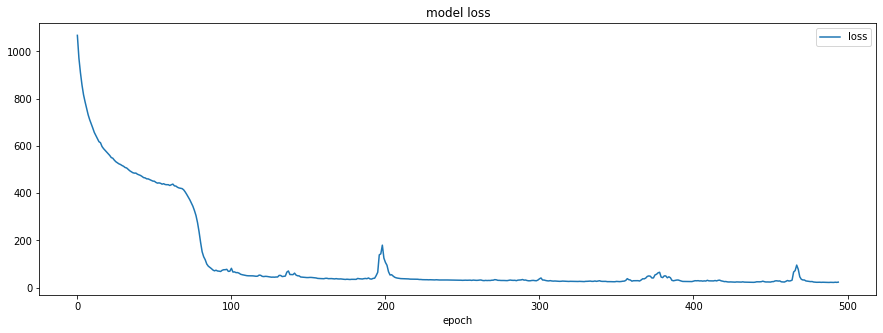

In [84]:
# Vemos cómo ha ido el entrenamiento

start_plot = 5

mpl.rcParams['figure.figsize'] = (15,5)
plt.plot(history_2.history['loss'][start_plot:], label = 'loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc ='upper right')
plt.show()

In [85]:
# Calculamos la salida del autoencoder en los valores 
# del experimento 1
decoded_imgs_2 = autoencoder_2.predict(input_data[mini:maxi])

Dibujamos las imágenes
* La primera línea es el original
* La segunda línea es la reconstrucción con el autoencoder del Experimento 1
* La tercera línea es la reconstrucción con el VAE que acabamos de crear

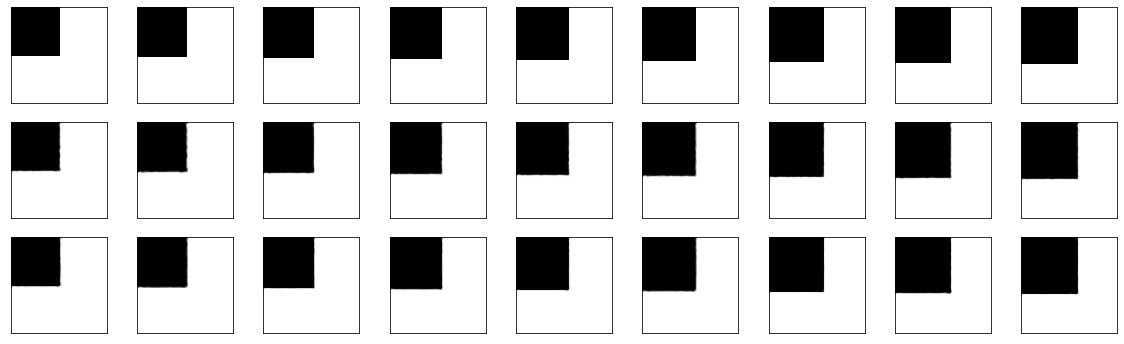

In [86]:
draw2compare(input_data[mini:maxi], decoded_imgs, decoded_imgs_2)

Calculamos los puntos del espacio latente que representan a las imágenes

In [87]:
latente_2 = encoder_2.predict(input_data)

Vemos una representación gráfica de ese conjunto de puntos. En este caso los puntos se agrupan en torno al cero y la desviación típica se acerca a 1.

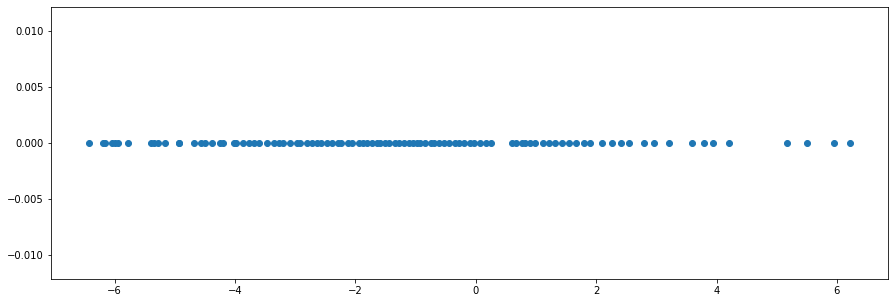

In [88]:
mpl.rcParams['figure.figsize'] = (15,5)
plt.scatter(latente_2[2],[0]*len(latente_2[2]))
plt.show()

Lo podemos representar mejor con un histograma

(0.0, 30.0)

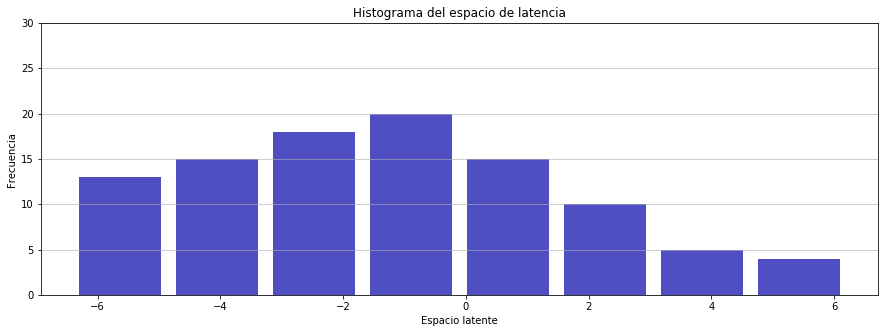

In [89]:
n, bins, patches = plt.hist(x=latente_2[2], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Espacio latente')
plt.ylabel('Frecuencia')
plt.title('Histograma del espacio de latencia')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

Si representamos juntos los puntos del espacio latente obtenido con el encoder o con el VAE sobre el mismo conjunto de puntos, vemos que los puntos de VAE están más próximos a una distribución normal estándar. Esta proximidad de los puntos del espacio latente en torno al cero es exactamente lo que estábamos buscando con los VAE. Esta distribución de los puntos va a hacer más fácil que seamos capaces de generar figuras nuevas.

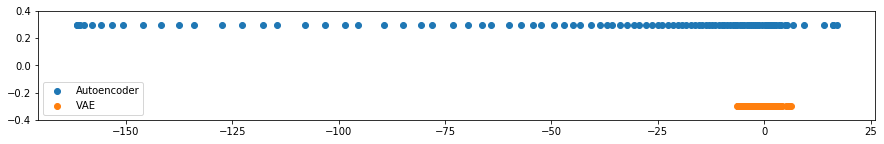

In [90]:
mpl.rcParams['figure.figsize'] = (15,2)
plt.scatter(latente_1,[0.3]*len(latente_1),label='Autoencoder')
plt.scatter(latente_2[2],[-0.3]*len(latente_2[2]),label='VAE')
plt.ylim(-0.4,0.4)
plt.legend()
plt.show()

# Experimento 6:

Como ocurría con el Experimento 1, el experimento anterior nos ha servido como primera toma de contacto con los VAE, pero podemos hacer cosas más interesante cuando aumentamos la dimensión del espacio latente.

En este caso, todo funciona igual, pero a cada  entrada de correponde una distribución de probabilidad normal multivariante alrededor de un punto en el espacio latente. Igual que antes, eso significa que, dada una imagen, en lugar de asignarle un único punto se le asignan todos los puntos del espacio latente y se indica cuál es la probabilidad de que un punto concreto del espacio latente sea una codificación de la imagen inicial. Al ser una distribución normal en cada componente, necesitamos dos parámetros para caracterizar cada coordenada del espacio latente (suponemos que no hay correlación entre las coordenadas), su media $\mu$ y su desviación típica $\sigma$. Podemos tomar aleatoriamente un punto $z$ del espacio latente usando $n$ distribuciones normales ($n$ es la dimensión del espacio latente) con un vector de $n$ valores que representa las medias $\mu$  de las distribuciones normales y un vector de $n$ valores que representa las desviacies típicas $\sigma$ de las distribuciones normales.

$$z = \mu + \sigma\epsilon$$

donde $\epsilon$ es un vector de $n$ componentes donde cada una de ellas se toma aleatoriamente de una distribución normal estándar.

$z$ es nuestro vector latente, que se genera a partir de $\mu$ y $\sigma$ que deberá aprender el autoencoder. Cada componente de $\epsilon$ se muestrea de una distribución normal estándar. 

En este caso, seguiremos usando las clases definidas anteriormente. Tendremos que modificar la codificador, pero el decodificador sigue manteniendo la misma estructura, así que vamos a partir de nuestra clase `Autoencoder` para implementa una nueva subclase `VariationalAutoencoder`. En la definicón de esta subclase usaremos una capa _Lambda_. 

In [91]:
# Por si has ejecutado antes esta práctica
# nos aseguramos de tener limpia la sesión de tensorflow
K.clear_session()

In [92]:
class VariationalAutoencoder(Autoencoder):
    
    def _create_latent_vector(self, encoder_input, x):
        # En vez de conectar directamente el vector aplanado al espacio latente 
        # se conecta a dos capas densas representante de mu y sigma.
        # Cada una de estas capas tiene tantas neuronas como indique z_dim,
        # esto es, tantas como indique la dimensión del espacio latente
        # Guardamos las capas en atributos de la clase porque nos hará falta 
        # para computar la función de coste. 
        self._mu = Dense(self.z_dim, name='mu')(x)                                          
        self._log_var = Dense(self.z_dim, name='log_var')(x)
        # Creamos un modelo auxiliar que nos servirá para obtener mu y sigma 
        # a partir de una imagen de entrada.
        self._encoder_mu_log_var = Model(encoder_input, (self._mu, self._log_var))    #(2)
        # Creamos la función sampling
        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon
        # Definimos una capa Lambda para usar la función sampling y muestrear
        # las capas self._mu y self._log_var donde codificamos la distribución de
        # probabilidad definida por mu y sigma.
        encoder_output = Lambda(sampling, name='encoder_output')([self._mu, self._log_var])   #(3)

        # La salida es un par de valores. El primero se elige entre las salidas 
        # de las z_dim neuronas de la capa densa self._mu y el segundo se elige 
        # entre las z_dim neuronas de la capa densa self._log_var. La probabilidad de elegir
        # una u otra neurona no es uniforme, sino que sigue la distribución normal 
        # marcada por mu y sigma.
        return encoder_output

Para comparar la diferencia, nos vamos a crear un autoencoder variacional con la misma estructura base que en el ejemplo del autoencoder para MNIST:

In [93]:
VAE_MNIST = VariationalAutoencoder(
         input_dim = (28,28,1)
        , encoder_conv_filters = [32,64,64,64]
        , encoder_conv_kernel_size = [3,3,3,3]
        , encoder_conv_strides = [1,2,2,1]
        , decoder_conv_filters = [64,64,32,1]
        , decoder_conv_kernel_size = [3,3,3,3]
        , decoder_conv_strides = [1,2,2,1]
        , z_dim = 2
        , activation = 'relu')       

Vamos a ver que se corresponde con la estructura esperada usando el método `plot_model` de Keras:

In [94]:
# Guardamos la imagen en el fichero 'vae_mnist.png'
plot_model(VAE_MNIST.encoder, show_shapes=True, show_layer_names=True,to_file='vae_mnist.png')

Vemos la imagen. Fíjate que ahora la red ya no apila una cada detrás de otra, sino que hay una bifurcación.


<img src='vae_mnist.png' width='70%' />

Como hemos visto, otro aspecto que cambia en los autoencoders variacionales es funcion de coste. La principal diferencia es que aquí queremos comparar dos distribuciones de probabilidad, de un lado la distribución normal estándar y otro la distribución normal que tiene $\mu$ y $\sigma$ como parámetros. Hay varias formas de comparar cómo de elejos están dos distribuciones de probabilidad. Aquí usaremos la divergencia de Kullback-Leibler (o _KL-divergence_). La métrica será una combinación de una métrica estándar (como puede ser la MSE) con la KL-divergencia, cada una de ellas multiplicada por un paraḿentro $\eta_1$ y $\eta_2$ que indica el grado de importancia de cada una de esas métricas.

El error lo computaremos como:

$$VAE_{loss} = \eta_1 METRICA + \eta_2 D_{KL}$$

donde $D_{KL}$, la KL- divergencia se calcula así

$$D_{KL} = \frac{1}{2} \sum^k_i (1 + log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

y $METRICA$ puede ser $MSE$, $Binary cross entropy$, $SSIM$, .... 

Al intentar minimizar este error, estamos buscando que el valor de MSE se parezca a cero y que la distribución de probabilidad se parezca a la distribución normal estándar con media 0 y desciación típica 1.

Para la implementación vamos a usar clases y el método `__call__` que nos da mayor flexibilidad. Implemaremos una clase para la $D_{KL}$. Esta clase debe recibir $\mu$ y $\sigma$. 

La clase `VAELoss` en el constructor creará una instancia de `KL_Loss` que usará en su método `__call__`:

In [95]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def bin_crossentropy(y_true, y_pred):
    return K.mean(binary_crossentropy(y_true, y_pred))

def ssim(y_true, y_pred):
    return 1 - K.mean(ssim_loss(y_true, y_pred))

class KL_loss:
    
    def __init__(self, mu, log_var):
        self.mu = mu
        self.log_var = log_var
        self.__name__ = 'kl_loss'
        
    def __call__(self, y_true, y_pred):
        return -0.5 * K.sum(1 + self.log_var - 
                            K.square(self.mu) - 
                            K.exp(self.log_var), axis = 1)
        
class VAELoss:
    
    def __init__(self, eta1, eta2, mu, log_var, base_metric=mse):
        self.eta1 = eta1
        self.eta2 = eta2
        self.base_metric = base_metric
        self.__kl_loss = KL_loss(mu, log_var)
        self.__name__ = 'vae_loss'

        
    def __call__(self, y_true, y_pred):
        return self.eta1 * self.base_metric(y_true, y_pred) + self.eta2 * self.__kl_loss(y_true, y_pred)

Ahora podemos compilar nuestro modelo. En este caso vamos a usar como métrica base la $SSIM$:

In [96]:
VAE_MNIST.model.compile(optimizer=Adam(0.0005), 
                           loss=VAELoss(1, 0.01, VAE_MNIST._mu, VAE_MNIST._log_var, 
                                        base_metric=ssim), 
                           metrics=[ssim_loss, mse, KL_loss(VAE_MNIST._mu, VAE_MNIST._log_var)])


Vamos a entrenar nuestra VAE para computar el espacio latente generado:

In [97]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
VAE_MNIST.model.load_weights('vae_mnist_weights.h5')

In [98]:
VAE_MNIST.model.fit(x=x_train_mnist, y=x_train_mnist, 
             validation_data=(x_test_mnist, x_test_mnist),
             batch_size=32, shuffle=True, epochs=50,
             callbacks=[PlotLossesKeras()])

In [99]:
# Si no habíamos guardado los pesos,
# los guardamos ahora
VAE_MNIST.model.save_weights('vae_mnist_weights.h5')

Vamos a mostrar ahora nuestro espacio latente:

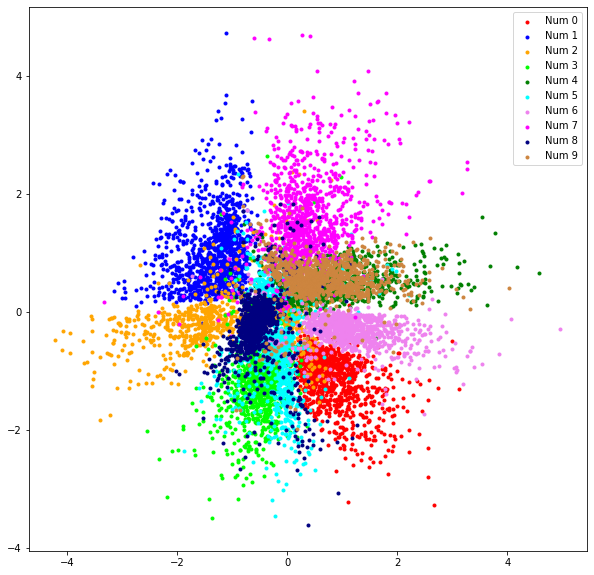

In [131]:
z_points_vae = VAE_MNIST.encoder.predict(x_test_mnist)

# Elegimos los colores con que vamos a representar cada número
colores = ['red','blue','orange','lime','green','cyan','violet','fuchsia','navy','peru']

for i in range(10):
    Xs_i = [z_points_vae[:,0][k] for k in range(len(z_points_vae)) if y_test_mnist[k] == i]
    Ys_i = [z_points_vae[:,1][k] for k in range(len(z_points_vae)) if y_test_mnist[k] == i]
    plt.scatter(Xs_i,Ys_i,c=colores[i],marker='.',label='Num '+str(i))

mpl.rcParams['figure.figsize'] = (10,10) # Para el tamaño de la imagen
plt.legend()
plt.show()

Podemos representar juntos el espacio latente obtenido por el autoencoder y por el VAE. Vemos que los puntos del VAE están más próximos a la distribución normal multinomial estándar.

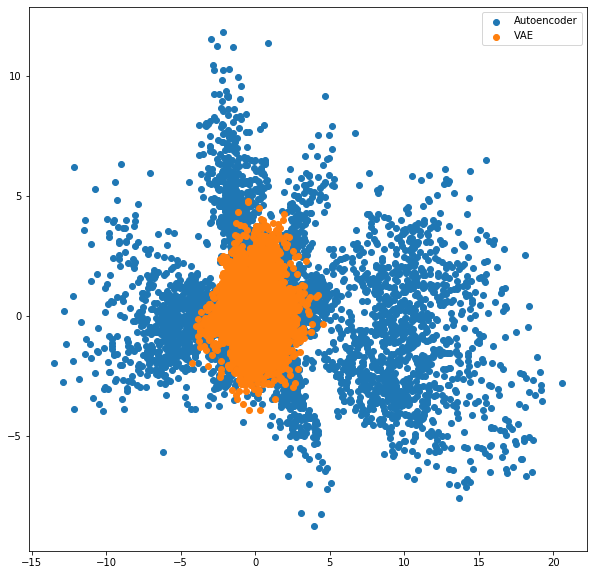

In [101]:
plt.scatter(z_points_ae[:,0],z_points_ae[:,1],label='Autoencoder')
plt.scatter(z_points_vae[:,0],z_points_vae[:,1],label='VAE')

mpl.rcParams['figure.figsize'] = (10,10) # Para el tamaño de la imagen
plt.legend()
plt.show()

También podemos usar la librría _seaborn_ que nos permite visualizar el histograma en cada dimensión. En este caso la varianza respecto a cada una de las componentes es mucho menor que en el espacio latente del autoencoder.

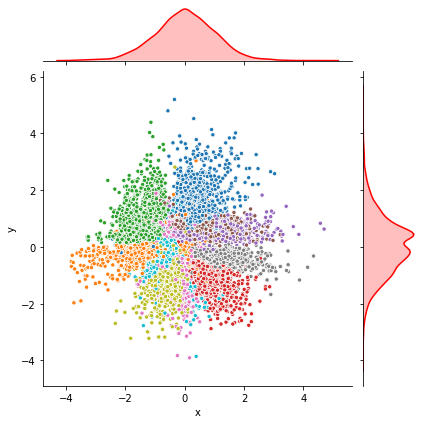

In [102]:
show_latent_space(VAE_MNIST, x_test_mnist)

Como en el caso anterior podemos hacer un muestreo de nuestro espacio latente. Dado que hemos hemos *obligado* a nuestro VAE a que el espacio esté centrado en 0 y tengan una desviación de 1 aproximadamente, podemos muestrear unicamente en el rango $\mu + 2\sigma$, esto es, (-4,4)

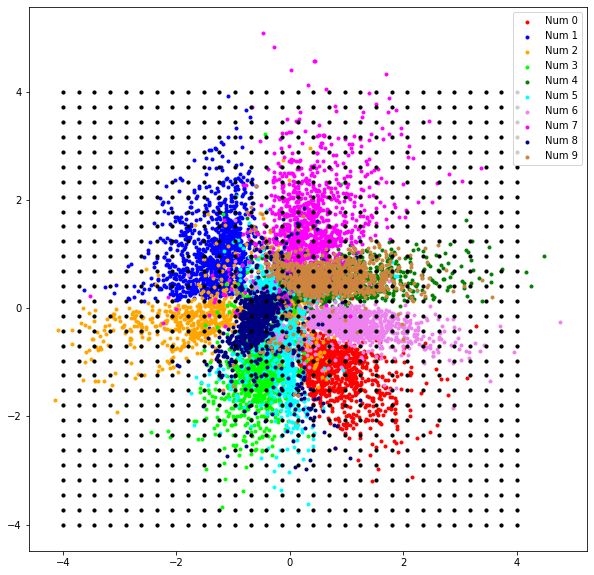


Representamos ahora la imagen asociada a cada uno de los puntos del grid 



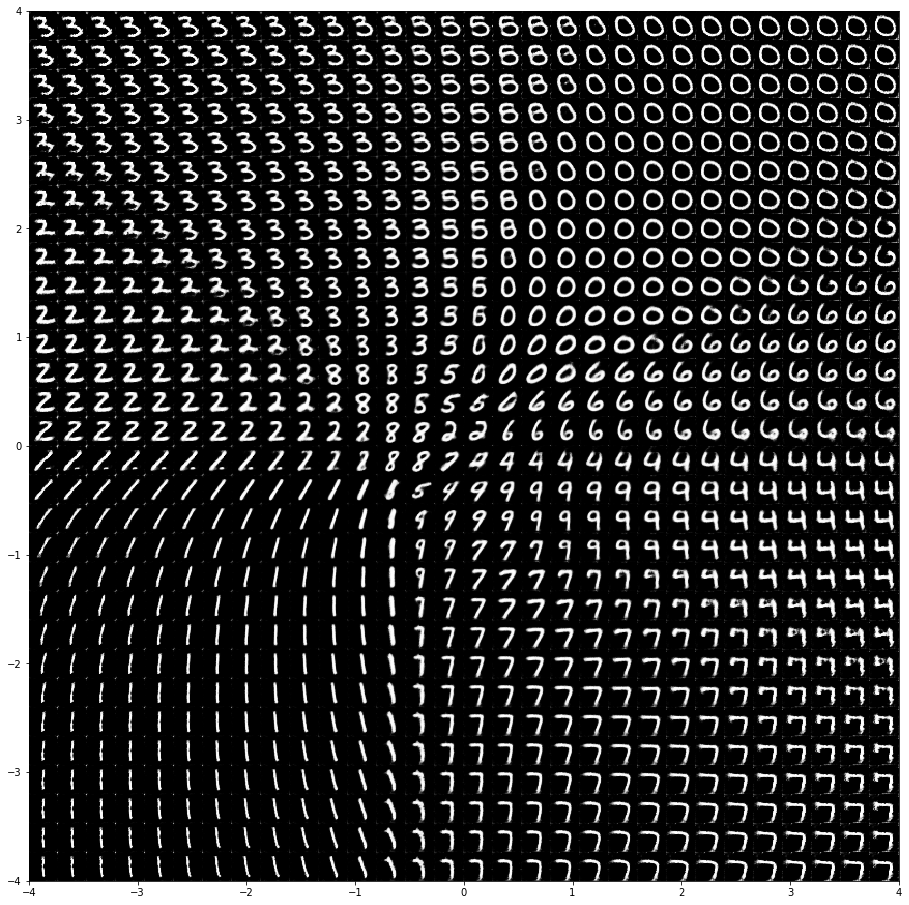

In [103]:
sample_latent_space(VAE_MNIST, x_range=(-4,4), y_range=(-4,4))

# Experimento 7

## Usando autoencoders variacionales para generar caras

Una de las razones por la que los VAE son tan populares es por el éxito en la generación de caras. En realidad, la técnica es la misma que hemos visto hasta ahora y para obtener precisiín fotográfica hacen falta máquinas realmente potentes, pero para terminar esta práctica vamos a hacer una pequeña aproximación.

En este ejercicio usaremos el conjunto de datos [CelebFaces Attributes (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) para entrenar nuestro siguiente autoencoder. Este conjunto de datos está compuesto por aproximadamente 200.000 imágenes de caras de famosos, cada una de ellas anotadas con una o más etiquetas del tipo: sonriendo, con gafas, llevando sombrero, etc...

<img src='img/celeba_sample.png' width='70%' />

No vamos a usar dichas etiquetas para entrenar nuestra VAE, pero nos serán de utilidad para llevar a cabo ciertas operaciones en el espacio latente.

Sera necesario que descargueis el archivo *img_align_celeba.zip* con las imágenes de [esta carpeta de google drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg) y que lo descomprimáis. También necesitaréis el archivo *list_attr_celeba.txt* con la etiquetas asociadas a cada imagen que podéis encontrar en [esta otra carpeta](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg). Yo he colocado las imágenes y el archivo con las etiquetas en un mismo directorio:

In [104]:
# Ruta en el ordenador de David
# DATA_FOLDER = '/home/dasolma/data/celeba'

# Ruta en el ordenador de Miguel
DATA_FOLDER = '/home/miguel/DL_data/Celeb_A'

IMG_FOLDER = os.path.join(DATA_FOLDER, 'images')
att_file = os.path.join(DATA_FOLDER, 'att.csv')

# obtenemos los nombres de los archivos de imágenes
file_names = os.listdir(IMG_FOLDER)

print('Total de imagenes: %d' % len(file_names))

Total de imagenes: 202599


El siguiente paso será crear nuestro VAE. Trabajamos con imagenes en color por lo que la entrada y la salida tendrán 3 canales. En este caso vamos a normalizar la salida de cada capa convolucional y vamos a aplicar un dropout del 25%.

El resto es prácticamente igual a los ejemplos anteriores:

In [105]:
INPUT_DIM = (128, 128, 3)

VAE_CELEBA = VariationalAutoencoder(
                        input_dim = INPUT_DIM
                        , encoder_conv_filters=[32,64,64, 64]
                        , encoder_conv_kernel_size=[3,3,3,3]
                        , encoder_conv_strides=[2,2,2,2]
                        , decoder_conv_filters=[64,64,32,3]
                        , decoder_conv_kernel_size=[3,3,3,3]
                        , decoder_conv_strides=[2,2,2,2]
                        , activation = ReLU
                        , z_dim=200
                        , use_batch_normalization=True
                        , dropout=0.25)

VAE_CELEBA.model.compile(optimizer=Adam(0.0005), 
                           loss=VAELoss(1, 1/10000, VAE_CELEBA._mu, 
                                        VAE_CELEBA._log_var, base_metric=mse), 
                           metrics=[ssim_loss, mse, KL_loss(VAE_CELEBA._mu, VAE_CELEBA._log_var)])

Este conjunto de datos tiene un tamaño total de 1.3GB en disco. El problema viene cuando convertimos la imágenes a array numpy de floats. El tamaño se multiplica llegando a pesar más de 30GB o más. Dado que no podemos cargar en memoria todas las imágenes, Keras nos da herramientas para trabajar con alimentación dinámica. Esto es, vamos a ir leyendo de disco los batches conforme vayan haciendo falta. Esta técnica ya la usamos en la práctica de redes convolucionales.

El procedimiento es muy sencillo. Usamos la clase `ImageDataGenerator` indicando el escalado y el porcentaje del conjunto de datos que queremos reservar para validación. Con el método `flow_from_directory` indicamos la carpeta donde se encuentran las imágenes, el tamaño del batch y con el atributo `subset` establecemos si ese flujo será de la parte reservada para entrenamietno o para validación. Por último tenemos que entrenar, que ahora lo haremos con el método `fit_generator`.

```
from keras_preprocessing.image import ImageDataGenerator

INPUT_DIM = (128,128,3)
BATCH_SIZE = 128


# creamos nuestro iterador indicando que tras leer la imagen se debe escalar dividiendo por 255
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_data_flow = data_gen.flow_from_directory(
    DATA_FOLDER, 
    target_size = INPUT_DIM[:2], 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    class_mode = 'input', 
    subset = "training")

val_data_flow = data_gen.flow_from_directory(
    DATA_FOLDER, 
    target_size = INPUT_DIM[:2], 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    class_mode = 'input', 
    subset = "validation")

steps_per_epoch = int((len(file_names) * 0.7) / BATCH_SIZE)

VAE_CELEBA.model.fit_generator(train_data_flow, validation_data=val_data_flow, shuffle = True, 
                               epochs = 200, callbacks = [PlotLossesKeras()], 
                               steps_per_epoch=steps_per_epoch 
    )
```

Con este código cada época tardaría unos 3min (por supuesto, depende del ordenador)

Si vamos a ejecutar 200 epocas, no llevaría el entrenamiento 600 min sin contar la evaluación. 

Recordamos que el conjunto de datos en disco ocupa 1.3GB. ¿Y si lo precargamos en memoria en binario? De esa forma evitamos la lectura a disco de los mismo archivos en cada época y dado que son solo 1.3GB no deberíamos tener muchos problemas de memoria. 

La función open() de python por defecto abre el fichero en formato texto. Para abrirlo en binario basta añadir 'b' en el parámetro 'modo'. El modo 'rb', por tanto, abre un fichero en modo binario. Si abres un fichero en modo binario, el contenido es ilegible, porque no estructura la información de un modo que tú puedas interpretar, pero es mucho más eficiente para manejar ficheros grandes. 

Este procedimiento los podemos hacer con una sola línea de código. Puedes obtener más información sobre la barra de progreso _tqdm_ en https://tqdm.github.io/

In [106]:
X = [open(os.path.join(DATA_FOLDER, 'images', f), 'rb').read() for f in tqdm(file_names)]

100%|██████████| 202599/202599 [00:04<00:00, 44158.98it/s]


Una vez leidos los archivos en memoria tendriamos que ir convirtiendolos a arrays de numpy. Vamos a ver cuando tardaríamos:

In [107]:
t_principio = time.time()
for im in tqdm(X):
    b = BytesIO(im)
    file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
    im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
t_final = time.time()
print('Esta operación ha tardado',t_final - t_principio,'segundos')

100%|██████████| 202599/202599 [01:57<00:00, 1718.10it/s]

Esta operación ha tardado 117.92236518859863 segundos


Se tardaría menos de dos minutos. Para aprovechar este truco tenemos que crearnos una clase que haga de iterador, como la clase `ImageDataGenerator` de Keras.

La implementación de clase sería la siguiente:

In [108]:
class CelebaInMemoryIterator(keras.utils.Sequence):
       
    def __init__(self, im_bytes, batch_size, shuffle=True):
        self.im_bytes = im_bytes
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.__len = int(len(self.im_bytes) / self.batch_size)
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # imagenes binarias del batch
        batch = [self.im_bytes[k] for k in indexes]

        # lista final de arrays
        ims = []
   
        # convertimos a numpy arrays
        for im in batch:
            b = BytesIO(im)
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (128, 128)) 
            ims.append(im)

        # escalamos a valores entre 0 y 1
        ims = np.array(ims).astype('float') / 255
        
        
        return ims, ims


    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(len(self.im_bytes)))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        
        return r
    

El método más importante es el método `__getitem__`. Este método recibe un parámetro `index` que indica el número de batch de nuestro conjunto de datos. Con ese número se debe preparar el batch y devolverlo.

El método `reset` simplemente reinicia a 0 el indice y baraja los indices si el atributo `shuffle` se estableció a true. Por último el métod `next` devuelve el siguiente batch a ser procesado. Básicamente controla si es necesario reiniciar el índice y lo incrementa en cada llamada.

Ahora podemos usar nuestra clase con `fit_generator`:

In [109]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 128

# dividimos el conjunto de datos entrenamiento y test
indexes = list(range(len(X)))
random.shuffle(indexes)
cut_point = int(len(X) * 0.7)
X_train = [X[i] for i in indexes[:cut_point]]
X_test = [X[i] for i in indexes[cut_point:]]    

# creamos los iteradores
train_generator = CelebaInMemoryIterator(X_train, 32)
test_generator = CelebaInMemoryIterator(X_test, 128)

In [110]:
# Si ya habíamos realizado el entrenamiento y tenemos los
# pesos guardados, no es necesario que volvamos a entrenar
# Podemos recuperarlos con
VAE_CELEBA.model.load_weights('vae_celeba_weights.h5')

In [111]:
# Entrenamos usando los iteradores


mi_checkpoint = ModelCheckpoint('vae_celeba_weights.h5', 
                                save_weights_only=True,
                                monitor='val_loss', 
                                save_best_only=True)

mi_earlystopping = EarlyStopping(monitor='val_loss', 
                                 mode='min', 
                                 patience=5)

mi_callbacks = [PlotLossesKeras(),mi_checkpoint,mi_earlystopping]


# VAE_CELEBA.model.fit_generator(train_generator, validation_data=test_generator, 
#                               epochs = 50, callbacks = mi_callbacks)

ModelCheckpoint ha guardado la mejor configuración de pesos obtenida. La cargamos. 

In [112]:
VAE_CELEBA.model.load_weights('vae_celeba_weights.h5')

Vamos a ver la calidad de la reconstrucción.

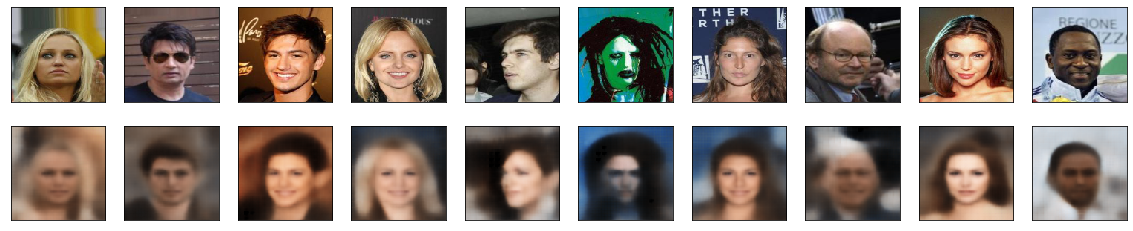

In [113]:
predict_generator = CelebaInMemoryIterator(X_test[:10], 10, shuffle=True)
x, _ = predict_generator.__next__()
draw2compare(x, VAE_CELEBA.model.predict(x))

Se aprecia que la VAE ha capturado algunos elementos clave de la cara (el ángulo de la cara, el peinado, la expresión, etc.) y que los detalles más finos se pierden. Aun así, es importante recordar que el objetivo no es realizar una reconstrucción perfecta (aunque sería deseable). El objetivo principal es poder hacer un muestreo en el espacio latente.

Vamos a realizar generar caras nuevas realizando un muestreo del espacio latente.

In [114]:
rows = 3
cols = 10
y = tuple([VAE_CELEBA.decoder.predict(np.random.normal(size=(cols, VAE_CELEBA.z_dim))) for _ in range(rows)])
#len(y), len(y[0])

Las siguientes son caras que no corresponden a imágenes del conjunto de entrada, sino que han sido genradas por el VAE.

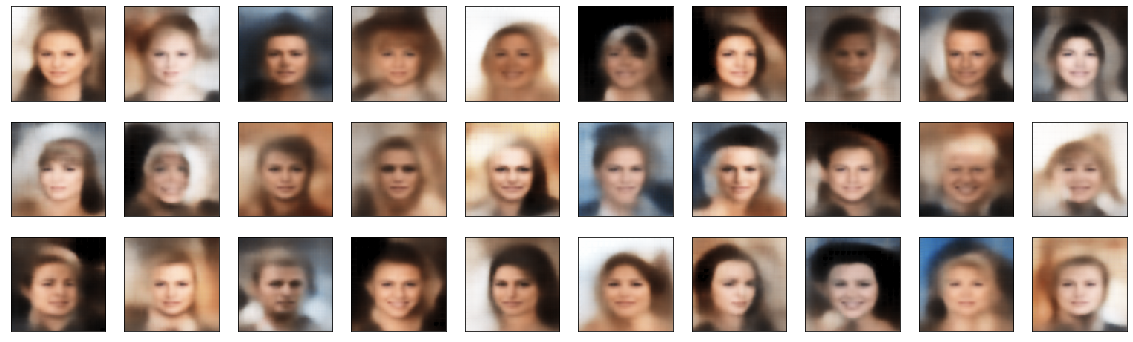

In [115]:
draw2compare(*y)

Es sorprendente como el VAE es capaz de crear imágenes de personas a partir de puntos tomados aleatoriamente.

### Aritmética en el espacio latente

Un beneficio de las representaciones en el espacio latente vectorial es que podemos llevar a cabo operaciones vectoriales y después decodificar el resultado de dicha operación.

Por ejemplo, supongamos que queremos hacer que una imagen de una alguien que tiene una expresión de tristeza la queremos convertir en sonriente. Para poder hacer esto necesitamos un vector latente que apunte en la dirección del espacio en el cual se incrementa la sonrisa. Si agregamos este vector a otro vector latente obtendremos un vector cuya imagen asociada será más sonriente que la orignal.

¿Como encontramos esos vectores direccionales? Para ello vamos a necesitar el conjunto de datos atributos. Cada imagen tiene asociada un conjunto de atributos, en ellos uno de es si esta sonriendo o no. Si calculamos la media de los vectores latentes de imágenes sonrientes y le restamos la media de los vectores latentes de imágnes no sonrientes obtedremos nuestro vector direccional que apunta desde *no sonriente* a *sonriente*.

El formato de este archivo un es poco especial y tenemos que hacerle unas modficaciones antes de poder leerlo. Un vez lo hemos leido vamos a reordenarlo que siga el mismo orden que nuestra lista de ficheros:

In [116]:
# Abrimos el archivo en modo lectura
with open(att_file, 'r') as fp:
    # eliminamos la primera línea, es el número de imágene el dataset (202599)
    lines = fp.readlines()[1:]
    # la siguiente linea es el nombre de cada columna  pero hay un espacio que debemos eliminar y agregar
    # una columna al principio para el nombre del fichero de imagen
    lines[0] = ('File_Name ' + lines[0]).strip() + '\n'
    # por último sustituimos los espacios por comas
    lines = [re.sub('[ ]+', ',', l) for l in lines]
    
# Leemos (parseamos) con pandas usando StringIO ya que tenemos el archivo en memoria
df_data = pd.read_csv(StringIO(''.join(lines)))

# Reordenamos el conjunto de datos para que tenga el mismo orden que nuestra lista de ficheros
df_data = df_data.set_index('File_Name').loc[file_names].reset_index()

# Mostramos las primreas filas del conjunto de datos
df_data.head()

File_Name  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  148239.jpg                -1                1           1               -1   
1  130670.jpg                -1                1           1               -1   
2  073915.jpg                -1               -1           1               -1   
3  016663.jpg                -1               -1          -1                1   
4  025413.jpg                -1               -1          -1                1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1      1        -1        -1           1  ...         -1       -1   
1    -1     -1        -1         1           1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1        1   
3    -1     -1         1         1           1  ...         -1        1   
4    -1     -1        -1         1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                -1           -1                 1   
1             -1          1                -1           -1                 1   
2             -1          1                -1           -1                 1   
3             -1         -1                -1           -1                -1   
4             -1         -1                -1           -1                -1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                -1               -1     -1  
4                -1               -1     -1  

[5 rows x 41 columns]

Como vemos tenemos una ficha por cada fichero identificado por su nombre. Cada columna corresponde a una caracterísca de esa imagen. Si la imagen tiene ese atributo está marcado con un 1, si no lo tiene está marcado con -1.

Podemos ver la lista de atributos de cada imagen.

In [117]:
df_data.columns

Index(['File_Name', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

Lo primero que vamos a hacer es seleccionar un atributo y calcular el vector medio de todos los vectores latentes que tienen ese atributo y los que no lo tienen. Para ello primero debemos obtener todos los vectores latentes. Vamos a usar nuestro iterador para ir obteniendo los vectores latentes e ir computando la media batch a batch:

In [118]:
# Elegimos un atributo
attribute = 'Smiling'

# tomamos los índices de que aquellas imágenes marcadas como 'soriendo' y aquellas que no
with_att_files = df_data[df_data[attribute] == 1].index
without_att_files = df_data[df_data[attribute] == -1].index

# creamos dos listas, una con los binarios de las imagnes marcadas como 'sonriendo' y la que no
X_with_att = [X[i] for i in with_att_files]
X_without_att = [X[i] for i in without_att_files]

def get_mean_vector(generator):
    
    mean_vector = None
    # usamos el generador para ir recorriendo los batches
    for i in tqdm(range(len(generator))):
        # obtenemos los vectors latentes del batch
        pred = VAE_CELEBA.encoder.predict(generator.__next__()[0])
        
        # si el primero calculamos la media de ese batch
        # en otro caso calculamos la media de la media de ese batch con la anterior
        if mean_vector is None:
            mean_vector = pred.mean(axis=0)
        else:
            mean_vector += pred.mean(axis=0)
            mean_vector /= 2
            
    return mean_vector

# obtenenmos el vector medio de las imágenes marcadas como 'sonriendo'
predict_generator = CelebaInMemoryIterator(X_with_att, 128, shuffle=False)
with_att_mean_vector = get_mean_vector(predict_generator)

# obtenenmos el vector medio de las imágenes marcadas como no 'sonriendo'
predict_generator = CelebaInMemoryIterator(X_without_att, 128, shuffle=False)
without_att_mean_vector = get_mean_vector(predict_generator)

100%|██████████| 819/819 [05:10<00:00,  2.64it/s]


Vamos a visualizar esos dos vectores del espacio latente que representan el punto medio de las imágenes "con atributo" y "sin atributo".

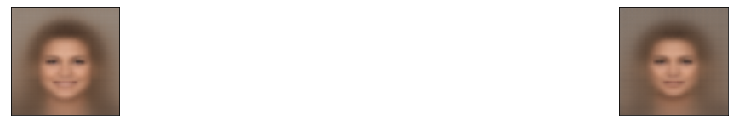

In [119]:
draw2compare(VAE_CELEBA.decoder.predict(np.array([with_att_mean_vector, without_att_mean_vector])))

Y ahora ya podemos calcular nuestro vector directional desde *no sonriente* a *sonriente*:

In [120]:
directional_vector = with_att_mean_vector - without_att_mean_vector

El siguiente paso es simplemente tomar una imagen de nuestro conjunto de datos e ir sumandole o restandole nuestro vector direccional y ver el efecto:

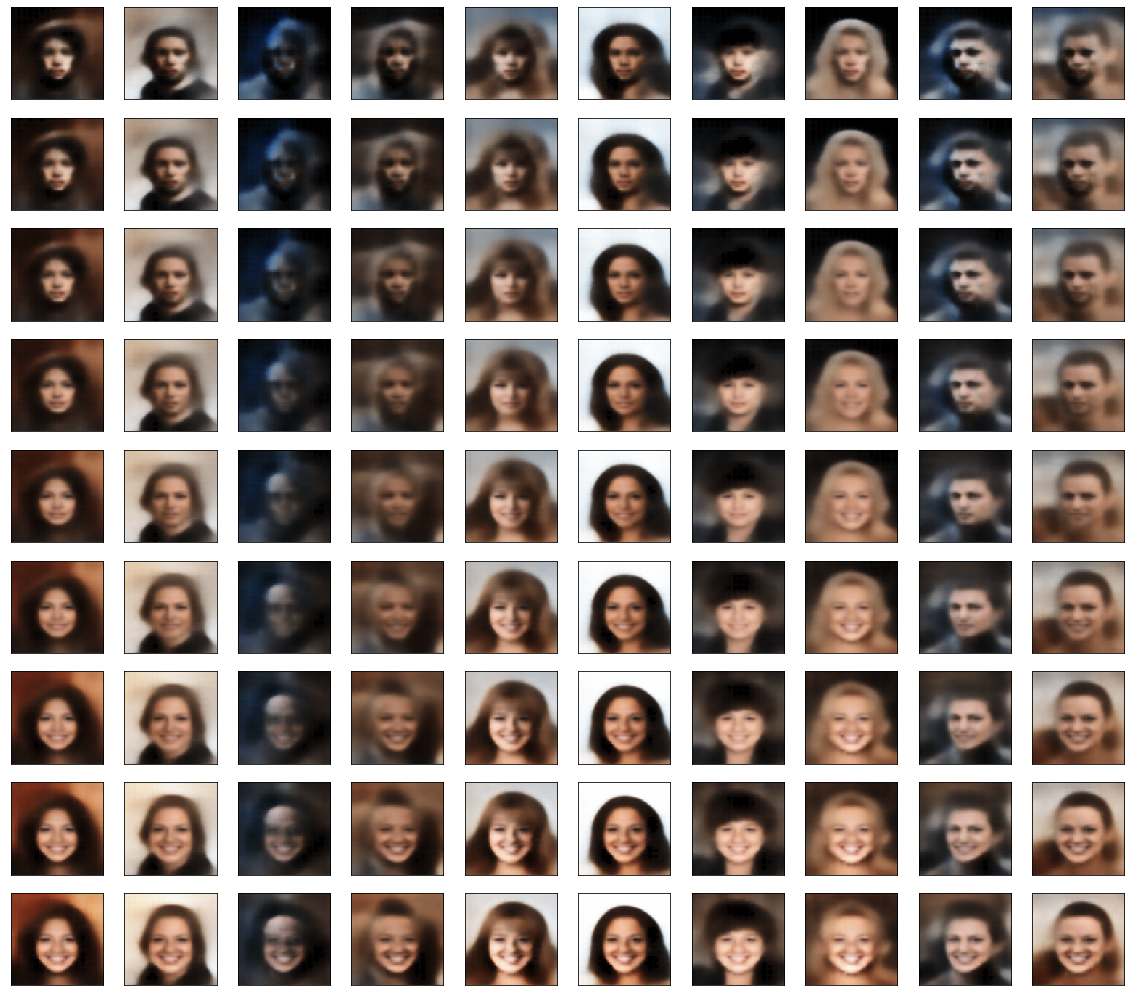

In [121]:
# obtenemos los vectores de 10 imágenes al azar
sample = CelebaInMemoryIterator(X, 10, shuffle=True).__next__()[0]
vectors = VAE_CELEBA.encoder.predict(sample)

# esta será la proporción del atributo que añadiremos a nuestros vectores
factors = [-4,-3,-2,-1,0,1,2,3,4]

# computamos la decoficación de los vectores modificador: v + f * d
changes = np.array([VAE_CELEBA.decoder.predict(vectors + f * directional_vector) for f in factors])

# mostramos
draw2compare(*list(changes))

Es sumamente interesante que aunque nos estamos alejando en el espacio latente desde el punto orignal la mayor parte de imagen no cambia excepto en lo que concierne a la característica que estamos modificando. Esto pone de manifiesto el poder de los autoencoders variacionales para capturar y permitirnos manipular características de alto nivel de abstracción.

Otra operación interesante que podemos llevar a cabo es la morphing. Esta consiste en tomar dos imágenes A y B y trazar una línea recta entre ambas en el espacio latente. Moviendomos a lo largo de esta línea podemos recrear la progresiva transformación de una cara en la otra:

Matemáticamente:

$$
z_{new} = (1 - \alpha) z_A - \alpha z_B
$$

donde $\alpha$ es un número entre 0 y 1 que determina en que posición entre el punto A y B nos encontramos (o que aportación del vector A y el vector B hay en el vector resultante).

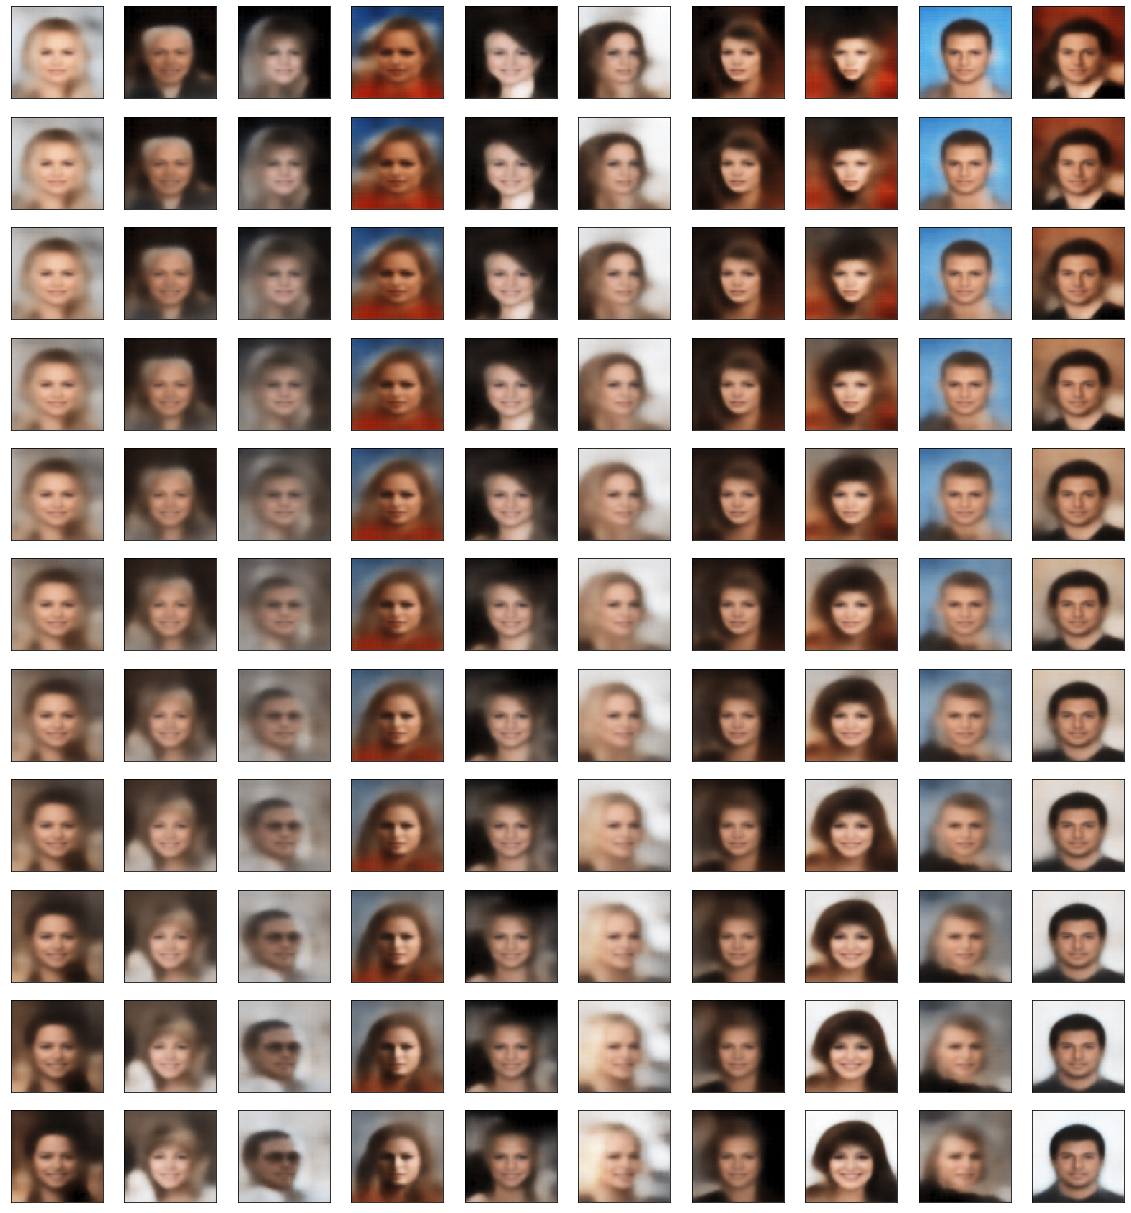

In [122]:
# Tomamos una lista de vectores A y vectores B
sample = CelebaInMemoryIterator(X, 10, shuffle=True).__next__()[0]
vectors_A = VAE_CELEBA.encoder.predict(sample)

sample = CelebaInMemoryIterator(X, 10, shuffle=True).__next__()[0]
vectors_B = VAE_CELEBA.encoder.predict(sample)

images = [VAE_CELEBA.decoder.predict(vectors_A)]
for alpha in np.arange(0,1,0.1)[1:]:
    z_new = VAE_CELEBA.decoder.predict((1-alpha)*vectors_A + alpha*vectors_B)
    images.append(z_new)
images.append(VAE_CELEBA.decoder.predict(vectors_B))

# mostramos
draw2compare(*images)

La transición se realiza suavemente incluiso cuando se están alterando varias características simultaneamente gracias a las continuidad del espacio latente.

Por último, puedes probar con tu foto, por ejemplo, añadiendo el atributo estudiado.

In [132]:
img_prueba = 'tu_foto.jpg'

image1 = img_to_array(image.load_img(img_prueba, target_size=(128,128,3))) / 255

In [133]:
latent_prueba = VAE_CELEBA.encoder.predict(image1.reshape(1,128,128,3))
factors_prueba = [-1,0,1,2,3,4]
changes_prueba = np.array([VAE_CELEBA.decoder.predict(latent_prueba + f * directional_vector) for f in factors_prueba])
draw2compare(*list(changes_prueba))

# Referencias

 - Generative Deep Learning. Teaching Machines to Paint, Write, Compose and Play. David Foster. O'Reilly
 - Advanced Deep Learning with Keras. Rowel Atienza. Packt.